# Fine-scale Prediction of Leaf Nitrogen Content and Yield in Sugarcane using UAV LiDAR and Multispectral Imaging

*Iurii Shendryk, Jeremy Sofonia, Robert Garrard, Yannik Rist, Danielle Skocaj, and Peter Thorburn* (2019)


This notebook contains codes used to produce results and figures presented in the paper.


### Contents

[Helper functions](#sec:helper_functions)

[Biomass Prediction](#sec:biomass_prediction)

 - [Load and preprocess data](#sec:load_data)

 - [Relationship between biomass measures](#subsec:biomass_measures)

 - [Principal components analysis](#sec:PCA)

 - [PCA factor loadings](#sec:factor_loadings)

 - [Biomass models](#sec:biomass_models)

 - [F-tests for biomass models](#subsec:biomass_ftests)

 - [Save models](#sec:save_models)
 
 
 [Apply Model to Whole Paddock](#sec:apply_model)
 
 - [Load data](#subsec:load_data_apply)

- [Predict paddock biomass](#sec:predict_paddock_biomass)
 
[Compare with SRA data](#sec:compare_SRA)

 - [Total vs stem biomass relationship](#sec:biomass_relationship_SRA)
 
 - [Biomass prediction comparison](#sec:SRA_biomass)

[Leaf Nitrogen Prediction](#sec:leaf_nitrogen)

 - [Load and preprocess data](#sec:load_N_data)
 
 - [Leaf N over time](#sec:leaf_N_over_time)
 
 - [PCA projection](#sec:PCA_projection)
 
 - [Add time trend predictor](#subsec:time_trend)
 
 - [Regression model](#sec:leaf_N_model)
 
 - [Benchmark - Avg NDVI](#sec:Benchmark_avgNDVI)
 
 - [Benchmark - Max NDVI](#sec:Benchmark_maxNDVI)
 
 - [Benchmark - N](#sec:Benchmark_N)
 
 - [F-tests for leaf N](#sec:ftests_leaf_N)

In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import datetime
import pickle
import math
import matplotlib
import matplotlib.pyplot as plt


# Models
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import statsmodels.api as sm
from statsmodels.regression.linear_model import OLSResults

from mpl_toolkits.axes_grid1 import make_axes_locatable

#####################
# Plot settings
%matplotlib inline
%config InlineBackend.figure_formats = set(['retina'])
%config InlineBackend.rc = {'figure.figsize': (1.618*4, 4)} # Plots as golden rectangles by default.
matplotlib.rc('font', **{'family': 'serif'})

import seaborn as sns
# Set text.usetex to False if you do not have LaTeX installed
sns.set(context='paper',
        style='whitegrid',
        font='serif',
        font_scale=2, 
        rc={'text.usetex': True})
sns.set_palette('deep')


# Save images to
img_path = './Images/'
# Save shape files to
shp_path = './Shape files/'

<a id="sec:helper_functions"></a>
## Helper functions

Since we'll be estimating models with a different number of predictors, and we won't be using an independent test set due to the small sample size, we'll want to use adjusted $R^{2}$ ($\bar{R}^{2}$) for model evaluation.

In [2]:
def adjustedR2(r2, n, p):
    '''
    Adjusted R squred.
    Inputs:
        - r2 (scalar). An R squared value for a linear regression.
        - n (scalar). Sample size used in the regression.
        - p (scalar). Number of predictors used in the regression including the constant. 
    
    Note that we use n - p in the denominator rather than n - p - 1 since the p we pass includes the constant.
    '''
    
    return 1 - (1 - r2)*( (n - 1) / (n - p))

<a id="sec:biomass_prediction"></a>
# Biomass Prediction

<a id="sec:load_data"></a>
## Load and preprocess data

For our biomass data set we have 6 survey periods. In each of the 6 periods, we survey two sugarcane paddocks identified as `WT1` and `WT2` in the data (the paddocks have different soil with different water drainage properties, hence 'Water drainage Type' 1 and 2). For each paddock, we conduct a UAV survey with a LiDAR sensor (hovermap) and a multispectral sensor (rededge). See Section 2 of the paper for a more complete description of the data set.

The data are stored in a set of shape files. Multispectral and LiDAR data are stored in the respective paths: `'../Data/Biomass_data/rededge/Train/'` and `'../Data/Biomass_data/hovermap/Train/'`.

In each path there are 12 shape files corresponding to the 6 different survey dates and 2 different paddocks. Files are named by paddock and date. For example, `WT1_biomass_171220_train.shp` in the rededge path corresponds to the multispectral training data for paddock WT1 on the date 20/12/17.

We first need no load and concatenate the multispectral data and LiDAR data separately into two data sets. The multispectral data set will contain: the unique ID for each transect, a set of variables to be predicted (Total biomass, leaf biomass, stem biomass, etc), additional variables (Nitrogen application rate, a paddock identifier), and a set of vegetation indices (see Section 2.4, tables 2 and 4). The LiDAR data set will contain: unique ID, same set of predictors and additional variables, and the LiDAR predictors (see Section 2.4, tables 3 and 4). 

Once we have these two data sets, we can then merge them on the unique ID, predictors and additional variables to form one data set. We need to merge them in order to estimate the multispectral/LiDAR fusion model, since we need the respective multispectral and LiDAR observations to refer to the same transect.

In [3]:
multispecDataPath = "./Data/Biomass_data/rededge/Train/"
lidarDataPath = "./Data/Biomass_data/hovermap/Train/"

dates = ['171108', '171220', '180131', '180315', '180426', '180606']

In [4]:
# Since we're loading shape files, use GeoPandas
multispec_raw = gpd.GeoDataFrame()
lidar_raw = gpd.GeoDataFrame()

for date in dates:
    temp1 = gpd.GeoDataFrame().from_file(multispecDataPath + 'WT1_biomass_' + date + '_train.shp')
    temp2 = gpd.GeoDataFrame().from_file(multispecDataPath + 'WT2_biomass_' + date + '_train.shp')    
    multispec_raw = gpd.GeoDataFrame(pd.concat([multispec_raw, temp1, temp2], axis=0))
    
    temp1 = gpd.GeoDataFrame().from_file(lidarDataPath + 'WT1_biomass_' + date + '_train.shp')
    temp2 = gpd.GeoDataFrame().from_file(lidarDataPath + 'WT2_biomass_' + date + '_train.shp')    
    lidar_raw = gpd.GeoDataFrame(pd.concat([lidar_raw, temp1, temp2], axis=0))
    

# Reset the indices
# We won't set Date to be the index at the moment,
# we'll do that on the merged data set.
multispec_raw = multispec_raw.reset_index()
lidar_raw = lidar_raw.reset_index()    

Since we're going to merge the data sets, let's drop the geometry column (for plotting maps with GeoPandas), otherwise we'll get two geometry columns in the merge.

We can also drop `index` and `Sample`, since we'll use `UNIQUE` as our unique identifier.

In [5]:
multispec_raw = multispec_raw.drop(['geometry', 'index', 'Sample'], axis=1)
lidar_raw = lidar_raw.drop(['geometry', 'index', 'Sample'], axis=1)

Currently the data is split across two files: one containing multispec data, one containing LiDAR. Both data sets begin with the following variables:


 - `UNIQUE` a unique identifier for each observation. The first three characters is the water type variable. 
 
 - `WT` water drainage type of the field the observation is from. WT1 and WT2, corresponding to poorly and well drained.
 
 - `N` - the ammount of nitrogen fertilizer applied to the cane in kg/H
 
 - `Stalks_num` - the number of stalks counted in the transect.
 
 - `Total_B_kg` - total biomass measured in the transect in kg.
 
 - `Stem_B_kg` - biomass of just the stems (part which contains sugar).
 
 - `Leaf_B_kg` - biomass contained in the leaves.
 
 - `Date` - the date at which the observation was taken.
 
 We want to merge these two data sets by the `UNIQUE` identifier because the observations are not in the same order in both data sets. However, we also want to remember the names of the multispec and LiDAR variables respectively, since we want to conduct PCA on these variables independently.

In [6]:
auxillary_var_names = ['UNIQUE', 'WT', 'N','Stalks_num', 'Total_B_kg', 'Stem_B_kg', 'Leaf_B_kg', 'Date']
multispec_var_names = sorted(list(set(multispec_raw.columns) - set(auxillary_var_names)))
lidar_var_names = sorted(list(set(lidar_raw.columns) - set(auxillary_var_names)))

Now let's merge the data sets to get everything matched up. Let's also set the `Date` variable to be the index for easier slicing (in year-month-day format).

In [7]:
data = pd.merge(multispec_raw, lidar_raw, on=auxillary_var_names)

# Set datetime index
data['Date'] = pd.to_datetime(data['Date'], format="%y%m%d")
data = data.set_index('Date')

# Since we're setting `Date` to be the index, drop it from the auxillary_vars
auxillary_var_names.remove('Date')

# Let's take a gander at our data.
data.head()

,UNIQUE,WT,N,Stalks_num,Total_B_kg,Stem_B_kg,Leaf_B_kg,max_NDVI,avg_NDVI,min_NDVI,...,b70,b75,b80,b85,b90,b95,d00,d01,d02,d03
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-08,wt1-01,WT1,70.0,35.0,25.3,20.1,4.6,0.773139,0.599807,0.305283,...,0.967,0.978,0.989,0.996,0.998,0.999,0.287,0.601,0.112,0.001
2017-11-08,wt1-02,WT1,70.0,20.0,21.6,17.4,3.7,0.727260,0.547928,0.324244,...,0.982,0.989,0.994,0.995,0.997,0.999,0.352,0.548,0.092,0.009
2017-11-08,wt1-03,WT1,190.0,44.0,32.7,15.4,5.3,0.724652,0.523674,0.297666,...,0.991,0.994,0.997,0.997,0.999,0.999,0.576,0.384,0.039,0.001
2017-11-08,wt1-04,WT1,0.0,28.0,21.1,17.0,3.5,0.775482,0.575587,0.313977,...,0.955,0.972,0.983,0.990,0.996,0.998,0.440,0.409,0.148,0.002
2017-11-08,wt1-05,WT1,0.0,31.0,29.3,24.3,5.0,0.787609,0.578986,0.318247,...,0.952,0.969,0.980,0.987,0.995,0.999,0.080,0.759,0.147,0.015


Great! We have the date as the index, predictors and additional variables, vegetation indices from the multispectral set, and heigh/density predictors from the LiDAR set. 


Now that the multispectral and LiDAR variables are matched up, let's pull them out in order to do PCA on each of them.

In [8]:
multispec_data = data[multispec_var_names]
lidar_data = data[lidar_var_names]

print('Multispec: ' + str(multispec_data.shape))
print('LiDAR: ' + str(lidar_data.shape))

Multispec: (336, 70)
LiDAR: (336, 46)


We have 70 multispec variables, and 46 LiDAR variables.

<a id="subsec:biomass_measures"></a>
### Relationship between biomass measures.

In the paper, we focus on predicting Total Biomass. Any future studies which acquire large samples will most likely be attempting to estimate total biomass only, since separating each stalk of sugarcane collected into leaf, stem, and number of stems is very time consuming compared to simply weighing the sample and moving on to the next (in a project to follow, we collect samples this way and achieve a sample size of $n \approx 250$ as opposed to $n = 56$ used here). Therefore, we focus on total biomass so that the linear models estimated here can serve as a benchmark for machine learning models trained on larger samples.

However, stem biomass is a more appropriate variable to predict since all of the sugar content of the cane resides in the stems. In order to see if the relationship is between stem biomass (and others) and total biomass is tight enough for total biomass to be a good proxy, let's plot some simple linear regressions of total biomass against other measures. 

This produces figure 5 in the article. Note that since the figure contains 3 subfigures, we enlarge the label font size so that it's readable in the article.

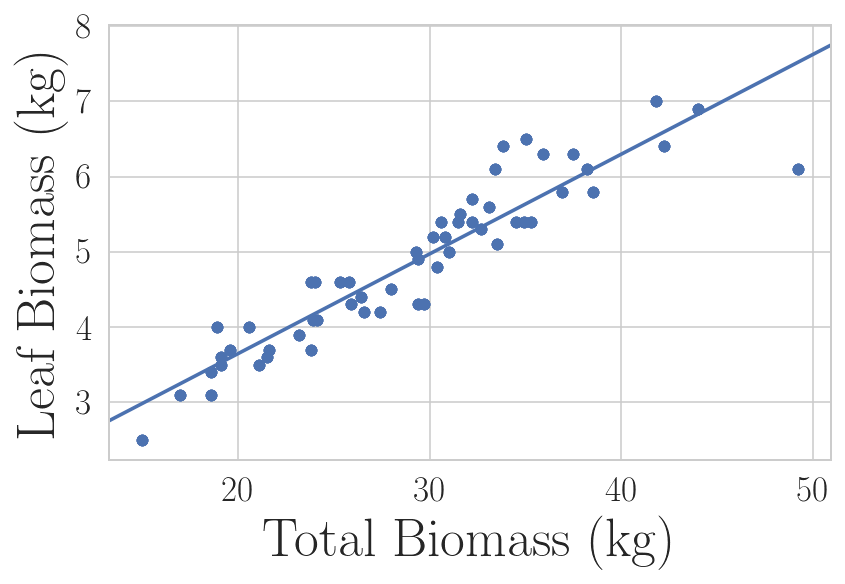

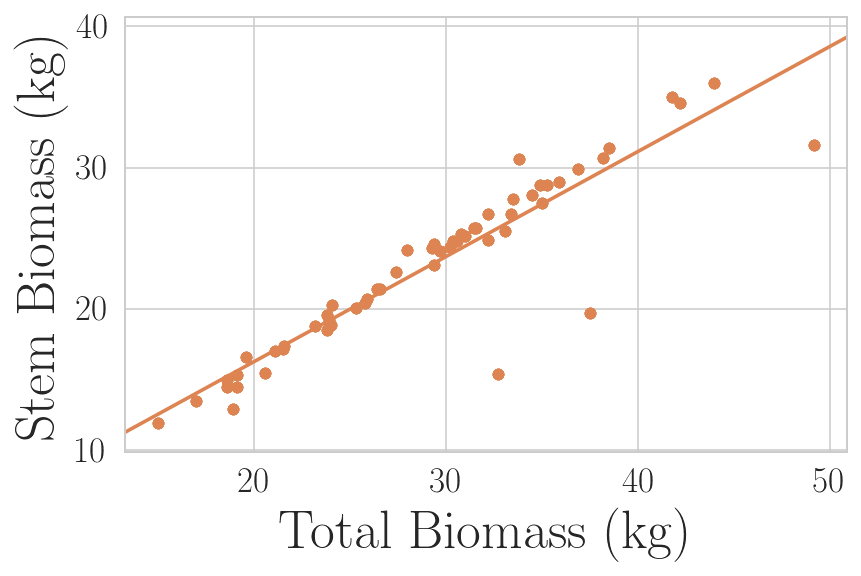

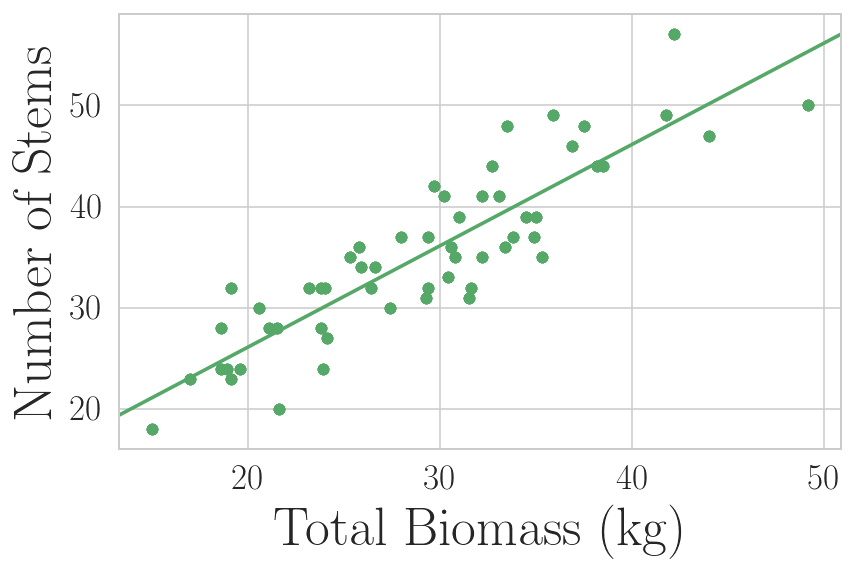

In [9]:
# Font size for labels and legend
fsize = 27
fsize_legend=18

# Leaf Biomass
plt.figure()
sns.regplot(x='Total_B_kg', y='Leaf_B_kg', data=data, ci=None)
plt.xlabel('Total Biomass (kg)', fontsize=fsize)
plt.ylabel('Leaf Biomass (kg)', fontsize=fsize)
plt.savefig(img_path + 'Figure5a.pdf', bbox_inches='tight', format='pdf', dpi=600)


# Stem
plt.figure()
sns.regplot(x='Total_B_kg', y='Stem_B_kg', data=data, ci=None, color=sns.color_palette()[1])
plt.xlabel('Total Biomass (kg)', fontsize=fsize)
plt.ylabel('Stem Biomass (kg)', fontsize=fsize)
plt.savefig(img_path + 'Figure5b.pdf', bbox_inches='tight', format='pdf', dpi=600)


# Number Stems
plt.figure()
sns.regplot(x='Total_B_kg', y='Stalks_num', data=data, ci=None, color=sns.color_palette()[2])
plt.xlabel('Total Biomass (kg)', fontsize=fsize)
plt.ylabel('Number of Stems', fontsize=fsize)
plt.savefig(img_path + 'Figure5c.pdf', bbox_inches='tight', format='pdf', dpi=600)

And $R^{2}$ for each.

In [10]:
X = data['Total_B_kg']
X = sm.add_constant(X)
y = data['Leaf_B_kg']
print('Total vs Leaf. R2 = {0:.2f}\n'.format(sm.OLS(y, X).fit().rsquared))

y = data['Stem_B_kg']
print('Total vs Stem. R2 = {0:.2f}\n'.format(sm.OLS(y, X).fit().rsquared))

y = data['Stalks_num']
print('Total vs Number of Stems. R2 = {0:.2f}\n'.format(sm.OLS(y, X).fit().rsquared))

Total vs Leaf. R2 = 0.86

Total vs Stem. R2 = 0.84

Total vs Number of Stems. R2 = 0.78



/home/gar303/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


We can see that the total biomass correlates strongly with the leaf and stem biomass, as well as the number of stalks.

<a id="sec:PCA"></a>
## Principal components analysis

Since the strategy is to train a model at each time point, we'll only have 56 observations in each time period but 70 multispec predictors. We need to do a dimension reduction to bring the number of predictors down. There are a few popular ways to do this:

- Pick a few predictors which are known a priori to work well, such as ones that have been established in the literature.
- Use principal components analysis to construct a new smaller set of predictors which explain most of the variance in the data.
- Use a subset selection (like best subset, forward stepwise) or regularization (like the lasso). Since these models have tuning parameters than get chose on the basis of goodness-of-fit (usually using a valiadtion set, Mallow's Cp, or an information criterion), to use any of these models requires us to have a test set for evaluating out-of-sample performance.


NDVI is a well established vegetation index. We will use NDVI as a benchmark. 

We choose to use PCA as the dimension reduction, rather than a machine learning method since the sample sizes are relatively small in each time period and so we want to avoid having to do training/test splits in order to perform model selection.

For PCA, model selection can be done by looking at the dependent variables only, not by checking goodness-of-fit on a validation set. To choose the number of components to retain without using goodness-of-fit, we can look at the scree plot for how much variance is explained by each successive component and look for an 'elbow'; or we can prespecify that we want as many components as explain a certain proportion of variance. We will keep as many components as explain 90% of the variance for each sensor, but for completeness we also check how this compares to the elbow method.

Before running PCA on the data, we want to first normalize the data by dividing through by its standard deviation. This makes each column dimensionless, and so predictors aren't treated differently because they're units are different. 

We will need to save this scaling later. In order to make a prediction on a new set of predictors, we will need to first divide them by the standard deviation estimated here, then project them through the PCA model. Note  that we don't need to demean them, since the PCA model stores the mean and demeans new observations automatically.

In [11]:
multispec_scale =  multispec_data.std()
lidar_scale = lidar_data.std()

In [12]:
# Do PCA on multispec and LiDAR independently. 
# Retain 10 components at first to generate the scree plot.
n_components = 10

# Scale data
multispec_data_scaled = multispec_data / multispec_scale
multispec_pca = PCA(n_components=n_components, whiten=True).fit(multispec_data_scaled)

In [13]:
lidar_data_scaled = lidar_data / lidar_scale
lidar_pca = PCA(n_components=n_components, whiten=True).fit(lidar_data_scaled)

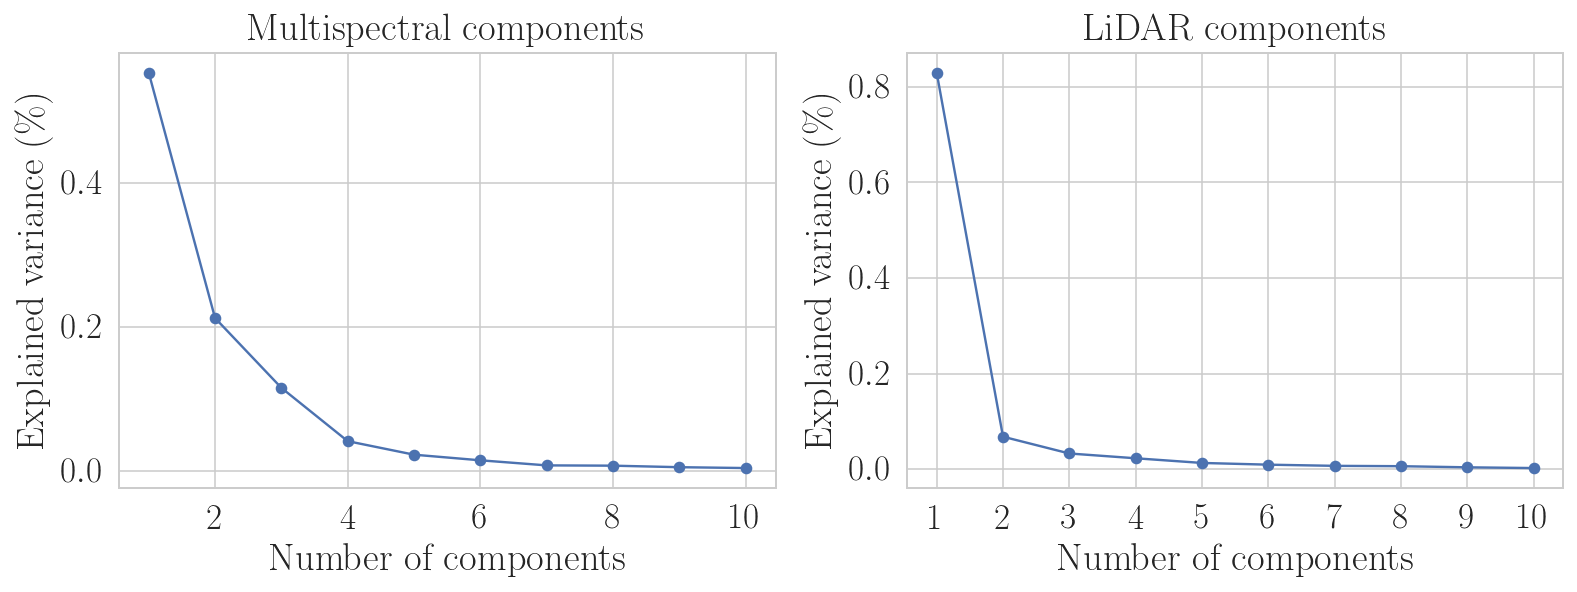

Cumulative explained variance: Multispec
[0.55266547 0.76452252 0.87944332 0.9203294  0.94242195 0.9567086
 0.96394777 0.97078449 0.97551019 0.97904572]

Cumulative explained variance: LiDAR
[0.82935772 0.89725979 0.93004387 0.95282327 0.96582765 0.97522651
 0.98216024 0.98836487 0.99221608 0.99453951]


In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(2*1.618*4, 4))

ax[0].plot(np.arange(1, n_components + 1), multispec_pca.explained_variance_ratio_, 'o-')
plt.xticks(np.arange(1, n_components + 1))
ax[0].set_title("Multispectral components")
ax[0].set_xlabel('Number of components')
ax[0].set_ylabel('Explained variance (\%)')

ax[1].plot(np.arange(1, n_components + 1), lidar_pca.explained_variance_ratio_, 'o-')
plt.xticks(np.arange(1, n_components + 1))
ax[1].set_xlabel('Number of components')
ax[1].set_ylabel('Explained variance (\%)')
ax[1].set_title("LiDAR components")
plt.show()

print("Cumulative explained variance: Multispec")
print(np.cumsum(multispec_pca.explained_variance_ratio_))
multispec_cumsum = np.cumsum(multispec_pca.explained_variance_ratio_)

print("\nCumulative explained variance: LiDAR")
print(np.cumsum(lidar_pca.explained_variance_ratio_))
lidar_cumsum = np.cumsum(lidar_pca.explained_variance_ratio_)



We can see pretty clear elbows on both plots. For multispectral components, the elbow method would retain 3 to 4 components, while for LiDAR it would retain 2 to 3.

From the cumulative explained variance, we see that 4 components are required to explain at least 90% of the variance for multispectral, and 3 components for LiDAR. So these two methods are in broad agreement.

Let's proceed with 4 components and 3 components for multispectral and LiDAR respectively.

In [15]:
# Do PCA to retain 90% variance.
multispec_pca = PCA(0.9).fit(multispec_data_scaled)
lidar_pca = PCA(0.9).fit(lidar_data_scaled)

# Store the number of components retained for each
n_components_multispec = multispec_pca.n_components_
n_components_lidar = lidar_pca.n_components_

Now that we've fit the PCA models, let's extract the principal components from our data sets and put them in the main data set as predictors.

In [16]:
# Turn the PCs into a data frame.
multispec_PCs = pd.DataFrame(multispec_pca.transform(multispec_data_scaled))
multispec_PCs.columns = ['MultispecPC' + str(i) for i in range(1, n_components_multispec+1)]
multispec_PCs = multispec_PCs.set_index(multispec_data.index)

lidar_PCs = pd.DataFrame(lidar_pca.transform(lidar_data_scaled))
lidar_PCs.columns = ['LiDARPC' + str(i) for i in range(1, n_components_lidar+1)]
lidar_PCs = lidar_PCs.set_index(lidar_data.index)

In [17]:
data = pd.concat([multispec_PCs, lidar_PCs, data], axis=1)
data.head(2)

,MultispecPC1,MultispecPC2,MultispecPC3,MultispecPC4,LiDARPC1,LiDARPC2,LiDARPC3,UNIQUE,WT,N,...,b70,b75,b80,b85,b90,b95,d00,d01,d02,d03
Date,,,,,,,,,,,,,,,,,,,,,
2017-11-08,12.284599,2.538661,0.613218,2.650119,10.91131,2.278741,0.300092,wt1-01,WT1,70.0,...,0.967,0.978,0.989,0.996,0.998,0.999,0.287,0.601,0.112,0.001
2017-11-08,12.882165,4.306252,-0.631058,-1.708743,11.20453,3.168638,0.663085,wt1-02,WT1,70.0,...,0.982,0.989,0.994,0.995,0.997,0.999,0.352,0.548,0.092,0.009


Great! We've retained 4 components for multispectral and 3 for LiDAR, and we've matched them up with their corresponding observations.

<a id="sec:factor_loadings"></a>
### PCA Factor Loadings

We're ready to start estimating models now, but before we do let's take a look at which predictors are being most heavily weighted in the construction of these principal components (look at the factor loadings).

In [18]:
multispec_loadings = multispec_pca.components_.T * np.sqrt(multispec_pca.explained_variance_)
multispec_loadings = pd.DataFrame(multispec_loadings, index=multispec_var_names)

lidar_loadings = lidar_pca.components_.T * np.sqrt(lidar_pca.explained_variance_)
lidar_loadings = pd.DataFrame(lidar_loadings, index=lidar_var_names)

Let's take a look at the top 5 predictors being represented in the first two principal components for multispectral and LiDAR each.

In [19]:
# Top 5 multispec predictors for each component

print("Multispectral:")
# Component 1
print("First component:")
print(multispec_loadings.iloc[(-multispec_loadings.iloc[:, 0].abs()).argsort()].iloc[0:5, 0])
print("\n")

# Component 2
print("Second component: ")
print(multispec_loadings.iloc[(-multispec_loadings.iloc[:, 1].abs()).argsort()].iloc[0:5, 1])

print("\n LiDAR:")
# Component 1
print("First component:")
print(lidar_loadings.iloc[(-lidar_loadings.iloc[:, 0].abs()).argsort()].iloc[0:5, 0])
print("\n")

# Component 2
print("Second component: ")
print(lidar_loadings.iloc[(-lidar_loadings.iloc[:, 1].abs()).argsort()].iloc[0:5, 1])

Multispectral:
First component:
avg_GDVI   -0.993716
p50_GDVI   -0.992089
p25_GDVI   -0.989593
avg_NDVI   -0.984818
p75_GDVI   -0.982311
Name: 0, dtype: float64


Second component: 
avg_EVI    -0.977129
p50_EVI    -0.970064
p75_EVI    -0.960708
p25_EVI    -0.937515
avg_SAVI   -0.855779
Name: 1, dtype: float64

 LiDAR:
First component:
b55    0.991617
avg   -0.990768
b60    0.990404
p60   -0.990019
b50    0.989763
Name: 0, dtype: float64


Second component: 
kur    0.931367
d00    0.578089
p10    0.506534
p15    0.470738
std   -0.411388
Name: 1, dtype: float64


For multispectral data we see that the first component is picking up GDVI and NDVI, noting that NDVI will be our benchmark.

<a id="sec:biomass_models"></a>
## Biomass models

For each survey period, we want to estimate the following models:

 - Model 1: Avg NDVI
 - Model 2: Max NDVI
 - Model 3: Multispectral principal components
 - Model 4: LiDAR principal components
 - Model 5: Fusion of multispectral and LiDAR PCs
 
For each of these models estimated in each time period, we want to record the metrics: $R^{2}$, adjusted $R^{2}$, and root mean square error (RMSE).


In addition, we also want to run the same set of models is the same time periods but where each model has the additional predictor of the initial nitrogen application rate.

So let's write a handy function that accepts a set of models (list of predictor names to use), a dependent variable to estimate (Total biomass, leaf biomass, stem biomass, number of stems), and loops through each date and estimates those models.

In [108]:
# Retrieve the set of 6 dates. 
dates = data.index.unique().tolist()
dates = [d.strftime("%Y-%m-%d") for d in dates]

# For plot labels, let's shorten it to just the month.
print(dates)
#date_labels = ['Nov', 'Dec', 'Jan', 'Mar','Apr', 'Jun']
date_labels = ["\# " + str(i) for i in list(range(1, 7))]
print(date_labels)
                                   



['2017-11-08', '2017-12-20', '2018-01-31', '2018-03-15', '2018-04-26', '2018-06-06']
['\\# 1', '\\# 2', '\\# 3', '\\# 4', '\\# 5', '\\# 6']


In [21]:
def Estimate_Models(Models,
                    LHS='Total_B_kg',
                    Dates=dates):
    '''
    Estimates OLS on each of the model specifications above in order to predict the LHS variable.
        
    Inputs:
     
     - Models (list of lists of strings). Each element is a list of names of right hand
     side variables to use. E.g., Models = [['avg_NDVI'], ['max_NDVI'], ['MultispectralPC1', 'MultispectralPC2']]
     
     - LHS (string). Name of the left hand side variable to use. E.g., LHS = 'Leaf_B_kg'. Default is total biomass.
     
    Outputs:
      - R2 (list of lists). List of R squares for each model in each time period. First index is date; e.g., date[0]
      is list of first time period metrics. Second index is model; e.g., R2[1][2] returns R squared for second survey, third model estimated.
      - adj_R2 (list of lists). Adjusted R squared. Analogous to the R2 output.
      - RMSE (list of lists). List of RMSEs for each model.
      - save_models (list). List of model objects so that an estimated model may be saved and later used in a prediction pipeline.
     '''
    
    # Empty list to store model metrics.
    R2 = []
    adj_R2 = []
    RMSE = []
    save_models = []
    
    for date in Dates:
        # LHS variable
        y = data[LHS].loc[date]
        
        R2_temp = []
        adj_R2_temp = []
        RMSE_temp = []
        save_models_temp = []
        
        for model in Models:
                      
            X = data[model].loc[date]
            X['const'] = 1
            
            # Convert dummy if necessary
            #if (model == M2): #or (model==M3) or (model==M5):
            if ('WT' in model):
                wt_dummy = pd.get_dummies(X['WT']).values[:, 0]
                X['WT'] = wt_dummy
            
            fit = sm.OLS(y, X).fit()
            
            # X dimensions
            n, p = X.shape
                    
            # Store the model
            save_models_temp.append(fit)
            
            R2_temp.append(fit.rsquared)
            RMSE_temp.append(np.sqrt(mean_squared_error(y, fit.predict(X))))
            adj_R2_temp.append(adjustedR2(fit.rsquared, n, p))
            
        R2.append(R2_temp)
        adj_R2.append(adj_R2_temp)
        RMSE.append(RMSE_temp)
        save_models.append(save_models_temp)
    
    return R2, adj_R2, RMSE, save_models
    

Now let's estimate models 1-5 in each date with total biomass as the LHS and plot the results. Then estimate the N-augmented models and plot.

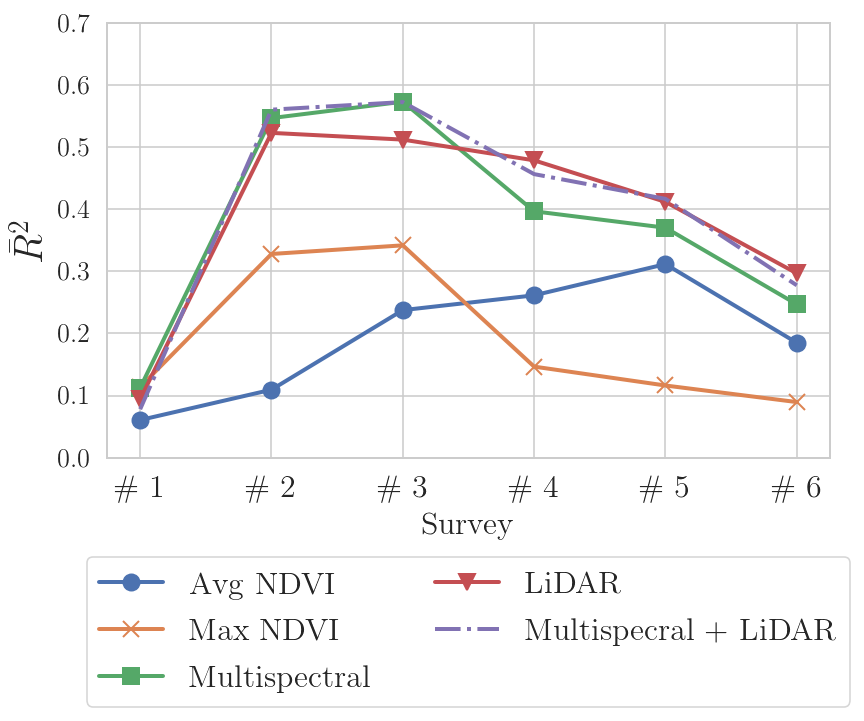

In [117]:
fsize = 20
fsize_legend=16

# Estimate models 1-5.
M1 = ['avg_NDVI']
M2 = ['max_NDVI']
M3 = ['MultispecPC' + str(i + 1) for i in range(n_components_multispec)]
M4 = ['LiDARPC' + str(i + 1) for i in range(n_components_lidar)]
M5 = M3 + M4
R2, adj_R2, RMSE, saved_models = Estimate_Models(Models=[M1, M2, M3, M4, M5])

# Plot adjusted R2 and save.
plt.figure()
fmt = ['-o', '-x', '-s', '-v', '-.']
for i, j in zip(np.array(adj_R2).T.tolist(), fmt):
    plt.plot(date_labels, i, j, linewidth=2, markersize=8)

plt.ylabel('$\\bar{R}^{2}$', fontsize=fsize)
plt.legend(['Avg NDVI', 'Max NDVI', 'Multispectral', 'LiDAR', 'Multispecral + LiDAR'], loc='center', bbox_to_anchor=(0.5, -0.4), ncol=2, fontsize=fsize_legend)
plt.ylim(0, 0.7)
plt.xticks(fontsize=fsize_legend)
plt.xlabel('Survey', fontsize=fsize_legend)

plt.savefig(img_path + 'Figure8a.pdf', bbox_inches='tight', format='pdf', dpi=600)


Let's get a read out of the adjusted $R^{2}$s. Columns represent dates, rows models. 

Could also replace `adj_R2` with regular `R2` or `RMSE`.

In [23]:
pd.DataFrame(adj_R2).T

,0,1,2,3,4,5
0,0.060701,0.109554,0.237603,0.261446,0.311657,0.185073
1,0.113992,0.328013,0.341904,0.146688,0.116295,0.089621
2,0.112676,0.546731,0.573094,0.396719,0.370252,0.247016
3,0.094350,0.522928,0.512113,0.478704,0.411834,0.296885
4,0.078149,0.560289,0.572503,0.456544,0.416724,0.277573


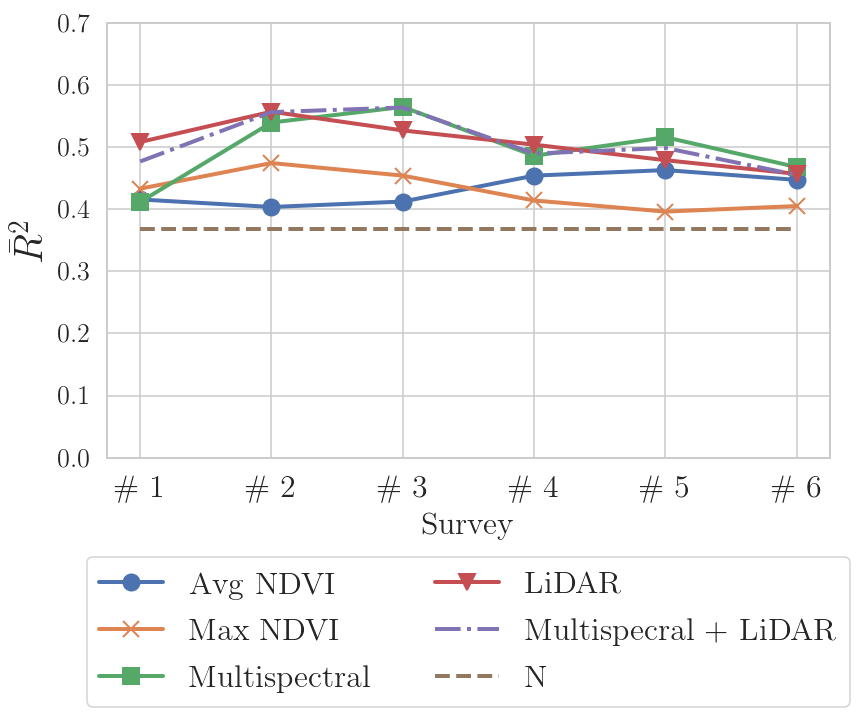

In [122]:
# Estimate models adding N as predictor
M1 = ['avg_NDVI', 'N']
M2 = ['max_NDVI', 'N']
M3 = ['MultispecPC' + str(i + 1) for i in range(n_components_multispec)] + ['N'] 
M4 = ['LiDARPC' + str(i + 1) for i in range(n_components_lidar)] + ['N']
M5 = M3 + ['LiDARPC' + str(i + 1) for i in range(n_components_lidar)]
M6 = ['N']
R2, adj_R2, RMSE, dump = Estimate_Models(Models=[M1, M2, M3, M4, M5, M6])

# Plot and save.
plt.figure()
fmt = ['-o', '-x', '-s', '-v', '-.', '--']
for i, j in zip(np.array(adj_R2).T.tolist(), fmt):
    plt.plot(date_labels, i, j, linewidth=2, markersize=8)
    
plt.legend(['Avg NDVI', 'Max NDVI', 'Multispectral', 'LiDAR', 'Multispecral + LiDAR', 'N'], loc='center', bbox_to_anchor=(0.5, -0.4), ncol=2,fontsize=fsize_legend)
plt.ylabel('$\\bar{R}^{2}$',fontsize=fsize)
plt.ylim(0, 0.7)
plt.xticks(fontsize=fsize_legend)
plt.xlabel('Survey', fontsize=fsize_legend)

plt.savefig(img_path + 'Figure8b.pdf', bbox_inches='tight', format='pdf', dpi=600)

Adjusted R squareds.

In [25]:
pd.DataFrame(adj_R2).T

,0,1,2,3,4,5
0,0.415728,0.403661,0.412368,0.454104,0.463054,0.447228
1,0.433154,0.474367,0.454108,0.414090,0.396241,0.405132
2,0.411798,0.539617,0.564664,0.486116,0.515895,0.467867
3,0.508208,0.557044,0.526844,0.503961,0.478941,0.456931
4,0.476884,0.556335,0.563768,0.489581,0.498591,0.455266
5,0.368862,0.368862,0.368862,0.368862,0.368862,0.368862


<a id="subsec:biomass_ftests"></a>
### F-tests for biomass models

We want to do a set of F-tests of multispectral only vs fusion and LiDAR only vs fusion in order to assess if the fusion model is adding any value.

Dec and Jan dates (surveys 2 and 3).

In [26]:
multispec_only = ['MultispecPC' + str(i + 1) for i in range(n_components_multispec)]
lidar_only = ['LiDARPC' + str(i + 1) for i in range(n_components_lidar)]
fusion = multispec_only + ['LiDARPC' + str(i + 1) for i in range(n_components_lidar)]

# Multispec vs fusion
print("Multispec vs Fusion\n")
for j in [1, 2]:
    y = data['Total_B_kg'].loc[dates[j]]
    X = data[multispec_only].loc[dates[j]]
    X['const'] = 1

    multispec_model = sm.OLS(y, X).fit()

    X = data[fusion].loc[dates[j]]
    X['const'] = 1

    fusion_model = sm.OLS(y, X).fit()

    pval = fusion_model.compare_f_test(multispec_model)[1]
    print('P-value: {0:.2f}\n'.format(pval))
    
    
print("LiDAR vs Fusion\n")
for j in [1, 2]:
    y = data['Total_B_kg'].loc[dates[j]]
    X = data[lidar_only].loc[dates[j]]
    X['const'] = 1

    lidar_model = sm.OLS(y, X).fit()

    X = data[fusion].loc[dates[j]]
    X['const'] = 1

    fusion_model = sm.OLS(y, X).fit()

    pval = fusion_model.compare_f_test(lidar_model)[1]
    print('P-value: {0:.2f}\n'.format(pval))

Multispec vs Fusion

P-value: 0.22

P-value: 0.41

LiDAR vs Fusion

P-value: 0.09

P-value: 0.03



Mar, Apr, May (surveys 4, 5, and 6).

In [27]:
multispec_only = ['MultispecPC' + str(i + 1) for i in range(n_components_multispec)]
lidar_only = ['LiDARPC' + str(i + 1) for i in range(n_components_lidar)]
fusion = multispec_only + ['LiDARPC' + str(i + 1) for i in range(n_components_lidar)]

# Multispec vs fusion
print("Multispec vs Fusion\n")
for j in [3, 4, 5]:
    y = data['Total_B_kg'].loc[dates[j]]
    X = data[multispec_only].loc[dates[j]]
    X['const'] = 1

    multispec_model = sm.OLS(y, X).fit()

    X = data[fusion].loc[dates[j]]
    X['const'] = 1

    fusion_model = sm.OLS(y, X).fit()

    pval = fusion_model.compare_f_test(multispec_model)[1]
    print('P-value: {0:.2f}\n'.format(pval))
    
    
print("LiDAR vs Fusion\n")
for j in [3, 4, 5]:
    y = data['Total_B_kg'].loc[dates[j]]
    X = data[lidar_only].loc[dates[j]]
    X['const'] = 1

    lidar_model = sm.OLS(y, X).fit()

    X = data[fusion].loc[dates[j]]
    X['const'] = 1

    fusion_model = sm.OLS(y, X).fit()

    pval = fusion_model.compare_f_test(lidar_model)[1]
    print('P-value: {0:.2f}\n'.format(pval))

Multispec vs Fusion

P-value: 0.05

P-value: 0.08

P-value: 0.18

LiDAR vs Fusion

P-value: 0.76

P-value: 0.36

P-value: 0.63



Multispectral only and fusion models from survey 3 perform best. Let's see if telling them the addional information of the initial N rate contributes to a significant increase in predictive power.

In [28]:
multispec_only = ['MultispecPC' + str(i + 1) for i in range(n_components_multispec)]
lidar_only = ['LiDARPC' + str(i + 1) for i in range(n_components_lidar)]
fusion = multispec_only + ['LiDARPC' + str(i + 1) for i in range(n_components_lidar)]
multispec_N = multispec_only + ['N']
fusion_N = fusion + ['N']


# Multispec vs fusion
print("Multispec with and without N\n")

y = data['Total_B_kg'].loc[dates[2]]
X = data[multispec_N].loc[dates[2]]
X['const'] = 1

multispecN_model = sm.OLS(y, X).fit()

X = data[multispec_only].loc[dates[2]]
X['const'] = 1

multispec_only_model = sm.OLS(y, X).fit()

pval = multispecN_model.compare_f_test(multispec_only_model)[1]
print('P-value: {0:.2f}\n'.format(pval))


# Multispec vs fusion
print("Fusion with and without N\n")

y = data['Total_B_kg'].loc[dates[2]]
X = data[fusion_N].loc[dates[2]]
X['const'] = 1

fusionN_model = sm.OLS(y, X).fit()

X = data[fusion].loc[dates[2]]
X['const'] = 1

fusion_model = sm.OLS(y, X).fit()

pval = fusionN_model.compare_f_test(fusion_model)[1]
print('P-value: {0:.2f}\n'.format(pval))


Multispec with and without N

P-value: 0.91

Fusion with and without N

P-value: 0.84



That's a solid No. In this survey period, the multispectral model doesn't get any better when it's told N.

<a id="sec:apply_model"></a>
# Apply Model to Whole Paddock.

Now that we've evaluated the models and found the best performing (multispectral only in the 3rd survey period), let's apply this model to predict at-harvest biomass for every 2mx2m transect in each paddock.Then we can compare these predictions to a set of independent measurements produced by Sugar Research Australia (SRA).

<a id="subsec:load_data_apply"></a>
## Load data

We need to load shape files for each paddock in the 3rd survey period.

In [29]:
paddock1_path = './Data/Biomass_data/rededge/Apply/WT1_biomass_180131_RE_apply.shp'
paddock2_path = './Data/Biomass_data/rededge/Apply/WT2_biomass_180131_RE_apply.shp'

paddock1_data = gpd.GeoDataFrame().from_file(paddock1_path)
paddock2_data = gpd.GeoDataFrame().from_file(paddock2_path)

paddock2_data = paddock2_data.dropna(axis=0) # A few NaNs in here.
paddock2_data.rename(columns={'N_Id': "N_id"}, inplace=True)

First we need to check that these contain the same set of predictors used in the above models.

In [30]:
# Extract multispectral predictors
X_paddock1 = paddock1_data.iloc[:, 3:-1]
X_paddock2 = paddock2_data.iloc[:, 3:-1]

# Check the lists contain the same set of predictors
print(f'Same set of predictors: {set(multispec_data.columns)==set(X_paddock1.columns) and set(multispec_data.columns)==set(X_paddock2.columns)}')

Same set of predictors: True


They have the same set of predictors, but unfortunately they happen to be out of order. We need to put them in the same order as the `multispec_data` predictors before we can use our PCA model.

In [31]:
X_paddock1 = X_paddock1.reindex(multispec_data.columns, axis=1)
X_paddock2 = X_paddock2.reindex(multispec_data.columns, axis=1)

Now these data sets have their predictors in the same order as the models above.

<a id="sec:predict_paddock_biomass"></a>
## Predict paddock biomass

First we need to project the multispectral vegetation indices through the PCA model to extract the first 4 principal components.

In [32]:
# Scale each data set by the estimated standard deviations.
X_paddock1 = X_paddock1 / multispec_scale
X_paddock2 = X_paddock2 / multispec_scale

# Project through PCA
PCs_paddock1 = pd.DataFrame(multispec_pca.transform(X_paddock1))
PCs_paddock1.columns = ['MultispecPC' + str(i) for i in range(1, n_components_multispec+1)]
PCs_paddock1 = PCs_paddock1.set_index(X_paddock1.index)

# Project through PCA
PCs_paddock2 = pd.DataFrame(multispec_pca.transform(X_paddock2))
PCs_paddock2.columns = ['MultispecPC' + str(i) for i in range(1, n_components_multispec+1)]
PCs_paddock2 = PCs_paddock2.set_index(X_paddock2.index)

# Add the principal components into the data sets
paddock1_data = pd.concat([PCs_paddock1, paddock1_data], axis=1)
paddock2_data = pd.concat([PCs_paddock2, paddock2_data], axis=1)

Now that we have the first 4 principal components, construct our predictor matrix (we'll reuse a variable name and call it X_paddock).

In [33]:
X_paddock1 = PCs_paddock1
X_paddock1['const'] = 1

X_paddock2 = PCs_paddock2
X_paddock2['const'] = 1

Now use these predictors and the multispectral-only model from survey period 3 to predict.

In [34]:
model = saved_models[2][2] # Period 3, 3rd model (multispec only)

# Paddock 1 predictions
paddock1_data = pd.concat([pd.DataFrame({'Predicted Biomass': model.predict(X_paddock1)}), paddock1_data], axis=1)
paddock2_data = pd.concat([pd.DataFrame({'Predicted Biomass': model.predict(X_paddock2)}), paddock2_data], axis=1)


paddock1_data = gpd.GeoDataFrame(paddock1_data)
paddock2_data = gpd.GeoDataFrame(paddock2_data)

In [35]:
paddock1_data.head(1)

,Predicted Biomass,MultispecPC1,MultispecPC2,MultispecPC3,MultispecPC4,N_id,N,Date,max_NDVI,avg_NDVI,...,p75_TGI,std_TGI,max_VARI,avg_VARI,min_VARI,p25_VARI,p50_VARI,p75_VARI,std_VARI,geometry
0,29.614746,4.642926,-4.942678,-2.130396,0.80552,0,0,180131,0.79466,0.704735,...,2.733651,0.580975,0.080137,0.043994,0.031361,0.040035,0.043169,0.046724,0.005973,"POLYGON ((393965.8010173076 8010289.763785952,..."


Plot our predictions

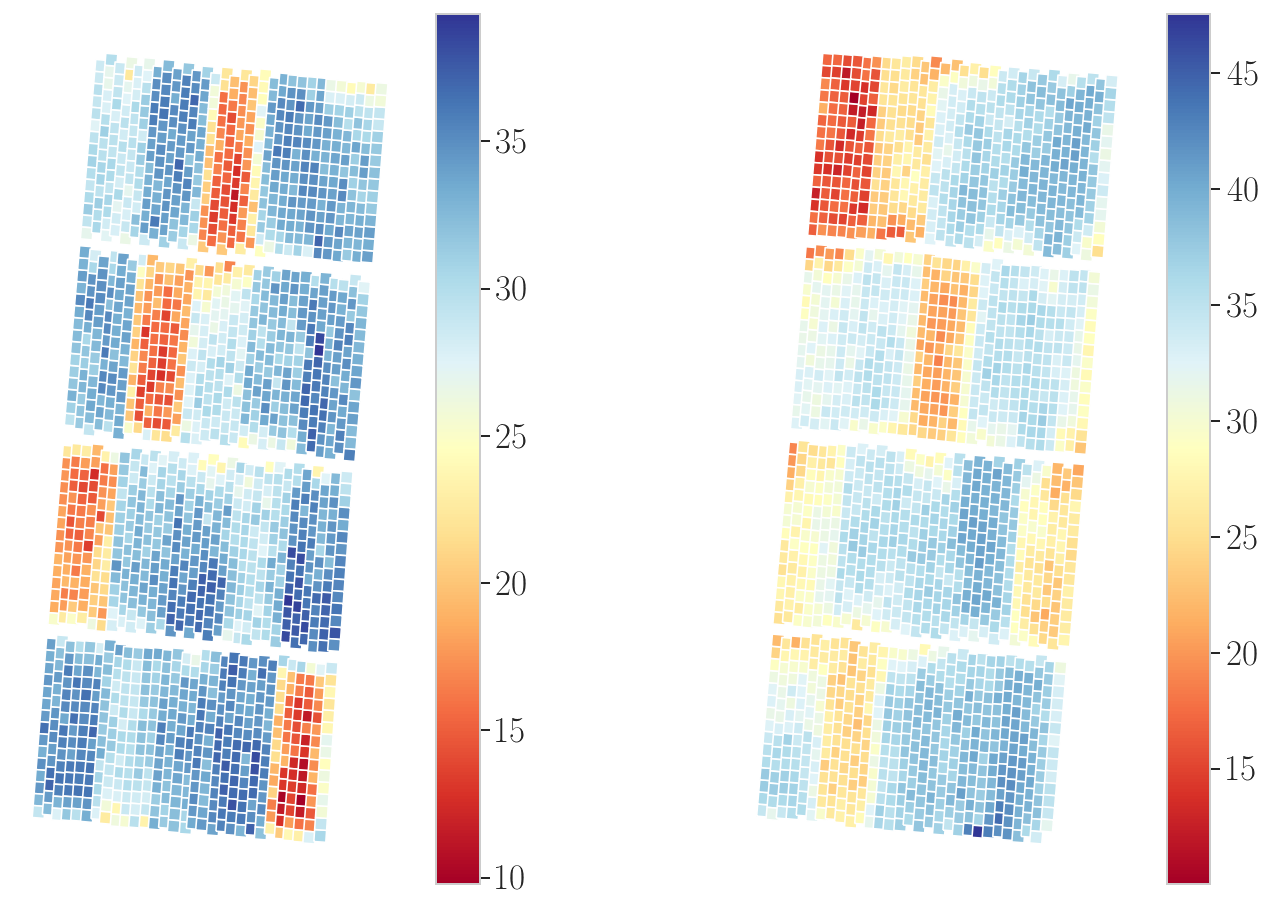

In [36]:
fig, ax = plt.subplots(1, 2, figsize=(12, 8))

ix_1 = paddock1_data['N_id'] > 0
ix_2 = paddock2_data['N_id'] > 0

paddock1_data.loc[ix_1].plot(column='Predicted Biomass', ax=ax[0],legend=True, cmap='RdYlBu')
paddock2_data.loc[ix_2].plot(column='Predicted Biomass', ax=ax[1], legend=True, cmap='RdYlBu')

ax[0].axis('off')
ax[1].axis('off')

plt.show()

Save these shape files to construct figure 9 with geopandas.

Now aggregate these fine scale predictions up to the treatment areas `N_id` so that we can compare our predictions with an independent set.

In [37]:
aggregated_1 = paddock1_data.groupby(['N_id']).agg(Total_cell_biomass=pd.NamedAgg('Predicted Biomass', sum))
paddock1_data = aggregated_1.merge(paddock1_data, on=['N_id'])

aggregated_2 = paddock2_data.groupby(['N_id']).agg(Total_cell_biomass=pd.NamedAgg('Predicted Biomass', sum))
paddock2_data = aggregated_2.merge(paddock2_data, on=['N_id'])

paddock1_data = gpd.GeoDataFrame(paddock1_data)
paddock2_data = gpd.GeoDataFrame(paddock2_data)

In [38]:
paddock1_data.head(1)

,N_id,Total_cell_biomass,Predicted Biomass,MultispecPC1,MultispecPC2,MultispecPC3,MultispecPC4,N,Date,max_NDVI,...,p75_TGI,std_TGI,max_VARI,avg_VARI,min_VARI,p25_VARI,p50_VARI,p75_VARI,std_VARI,geometry
0,0,18474.344425,29.614746,4.642926,-4.942678,-2.130396,0.80552,0,180131,0.79466,...,2.733651,0.580975,0.080137,0.043994,0.031361,0.040035,0.043169,0.046724,0.005973,"POLYGON ((393965.8010173076 8010289.763785952,..."


<a id="sec:compare_SRA"></a>
# Compare with SRA measurements.

As described in section 2.2, SRA conducted an independent biomass estimation around the harvest date. Let's compare the model's predictions to SRA's measurements.

Note that these measurements are not at fine scale, they estimates of the total biomass in each N application trial cell. 

In [39]:
SRA_data_path = "./Data/SRA/SRA_yield_WT1_and_WT2_2018.csv"
SRA_data = pd.read_csv(SRA_data_path)

In [40]:
SRA_data.head(2)

,Site,Plot_ID,Crop,Rep,Treatment (kgN/ha),Sample_Date,Stalk_Population,Total_Fresh_Biomass,Cane_Yield
0,WT1,1,3R,1,110,30/07/2018,9.97,98.36,78.41
1,WT1,2,3R,1,150,30/07/2018,11.81,123.38,99.40


<a id="sec:biomass_relationship_SRA"></a>
### Total vs stem biomass relationship

We see that the SRA data set contains estimates of total fresh biomass (what we've been calling total biomass; stem + leaf) and cane yield (what we've been calling stem biomass). Earlier we regressed total biomass against stem biomass ([here](#subsec:biomass_measures)) and got an $R^{2} = 0.84$. Looking at that plot, we see three clear outliers. Let's remove these outliers and see how it compares to the SRA data.

Outliers are `UNIQUE` = 'wt1-03', 'wt1-23', and 'wt1-22'.

In [41]:
outliers = ['wt1-03', 'wt1-23', 'wt1-22']
ix = [not(i in outliers) for i in data['UNIQUE']]
data_minus_outliers = data.loc[ix]

In terms of units, our measurements are kg of biomass in a $4m^{2}$ transect. SRA estimated tonnes of biomass in a hectare ($10,000 m^{2}$). In order for our observations to be on the same scale, we need to convert $kg/m^{2}$ to $t/ha$, which means multiplying by 2.5.

In [42]:
data_minus_outliers['Stem_B_kg'] = data_minus_outliers['Stem_B_kg']*2.5
data_minus_outliers['Total_B_kg'] = data_minus_outliers['Total_B_kg']*2.5

/home/gar303/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/gar303/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Let's rerun our linear model for the relationship of Total and stem biomass with these outliers removed and see if there's any change.

In [43]:
X = data_minus_outliers.loc['2018-06-06']['Total_B_kg']
X = sm.add_constant(X)
y = data_minus_outliers.loc['2018-06-06']['Stem_B_kg']

our_model = sm.OLS(y, X).fit()
print('Total vs Stem. R2 = {0:.2f}\n'.format(our_model.rsquared))
our_model.summary()

Total vs Stem. R2 = 0.98



/home/gar303/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Stem_B_kg   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     3156.
Date:                Wed, 06 Nov 2019   Prob (F-statistic):           1.53e-47
Time:                        09:38:14   Log-Likelihood:                -107.84
No. Observations:                  53   AIC:                             219.7
Df Residuals:                      51   BIC:                             223.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.7402      1.105     -2.480      0.016      -4.959      -0.522
Total_B_kg     0.8484      0.015     56.182      0.000       0.818       0.879
==============================================================================
Omnibus:                       18.414   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               51.002
Skew:                           0.801   Prob(JB):                     8.41e-12
Kurtosis:                       7.531   Cond. No.                         312.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From removing the 3 outliers, we now have a *very* strong relationship between total biomass and stem biomass, with $R^{2} = 0.984$.

Run a similar model for the SRA data.

In [44]:
X = SRA_data['Total_Fresh_Biomass']
X = sm.add_constant(X)
y = SRA_data['Cane_Yield']

their_model = sm.OLS(y, X).fit()
their_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Cane_Yield   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.986
Method:                 Least Squares   F-statistic:                     2656.
Date:                Wed, 06 Nov 2019   Prob (F-statistic):           8.91e-37
Time:                        09:38:14   Log-Likelihood:                -90.977
No. Observations:                  40   AIC:                             186.0
Df Residuals:                      38   BIC:                             189.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -8.1751      2.063     -3.964      0.000     -12.350      -4.000
Total_Fresh_Biomass     0.8941      0.017     51.539      0.000       0.859       0.929
==============================================================================
Omnibus:                        5.003   Durbin-Watson:                   2.219
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                2.123
Skew:                           0.209   Prob(JB):                        0.346
Kurtosis:                       1.952   Cond. No.                         643.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The SRA data set also sees a very strong relationship with a similar $R^{2} = 0.986$.

The coefficients in each model are very similar also. Let's plot both our and SRA's data on the same graph.

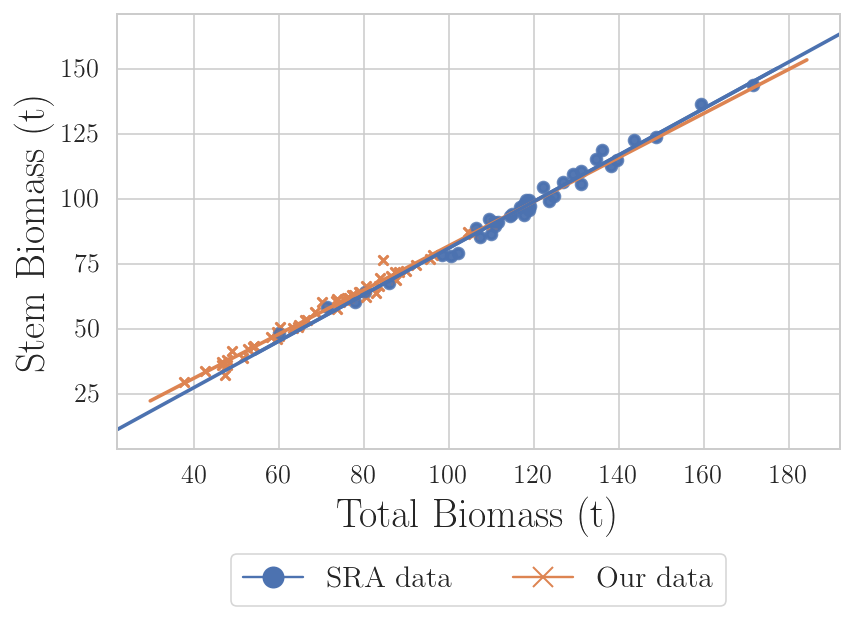

In [176]:
plt.figure()
fsize = 20

sns.regplot(x='Total_Fresh_Biomass', y='Cane_Yield', data=SRA_data, ci=None, color=sns.color_palette()[0], marker='o', scatter_kws={'linewidths':2})
sns.regplot(x='Total_B_kg', y='Stem_B_kg', data=data_minus_outliers, ci=None, color=sns.color_palette()[1],marker='x', scatter_kws={'linewidths':2})
sns.regplot(x='Total_Fresh_Biomass', y='Cane_Yield', data=SRA_data, ci=None, color=sns.color_palette()[0])

#plt.legend([matplotlib.markers.MarkerStyle('x'), matplotlib.markers.MarkerStyle('o')])
plt.legend(handles=[matplotlib.lines.Line2D([0], [0], marker='o', label='SRA data', markerfacecolor=sns.color_palette()[0], markersize=10),
                    matplotlib.lines.Line2D([0], [0], marker='x', label='Our data', color=sns.color_palette()[1], markerfacecolor=sns.color_palette()[1], markersize=10)],
          loc='center', bbox_to_anchor=(0.5, -0.3), ncol=2,fontsize=15)

#plt.legend(loc='center', bbox_to_anchor=(0.45, -0.35), ncol=6,fontsize=13).texts[0].set_text('Treatment\n (kgN/ha)')

plt.xlabel('Total Biomass (t)', fontsize=fsize)
plt.ylabel('Stem Biomass (t)', fontsize=fsize)

plt.savefig(img_path + 'Figure10a.pdf', bbox_inches='tight', dpi=600)

<a id="sec:SRA_biomass"></a>
### Compare SRA biomass measures

In [46]:
SRA_data.Plot_ID = SRA_data.Plot_ID.astype(str)
SRA_data["ID"] = SRA_data["Site"].map(str) + '_' + SRA_data["Plot_ID"]

In [47]:
paddock1_data['FID']='WT1'
paddock2_data['FID']='WT2'
drone = pd.concat([paddock1_data, paddock2_data], axis=0)

drone.N_id = drone.N_id.astype(int)
drone.N_id = drone.N_id.astype(str)

drone["ID"] = drone["FID"].map(str) + '_' + drone["N_id"]

The drone data is at the transect level. Let's aggregate it up to the block level.

In [48]:
merged_data = pd.merge(SRA_data, drone, on='ID')

In [49]:
merged_data.head()

,Site,Plot_ID,Crop,Rep,Treatment (kgN/ha),Sample_Date,Stalk_Population,Total_Fresh_Biomass,Cane_Yield,ID,...,std_TGI,max_VARI,avg_VARI,min_VARI,p25_VARI,p50_VARI,p75_VARI,std_VARI,geometry,FID
0,WT1,1,3R,1,110,30/07/2018,9.97,98.36,78.41,WT1_1,...,0.521089,0.076507,0.037453,0.019248,0.028925,0.035585,0.043785,0.010469,"POLYGON ((394011.4878364152 8010352.902143315,...",WT1
1,WT1,1,3R,1,110,30/07/2018,9.97,98.36,78.41,WT1_1,...,0.580503,0.088997,0.037705,0.018570,0.027951,0.032755,0.044628,0.013140,"POLYGON ((394011.6376823958 8010354.896521961,...",WT1
2,WT1,1,3R,1,110,30/07/2018,9.97,98.36,78.41,WT1_1,...,0.525985,0.075046,0.035169,0.019091,0.028446,0.032273,0.040517,0.009015,"POLYGON ((394011.7875283763 8010356.890900607,...",WT1
3,WT1,1,3R,1,110,30/07/2018,9.97,98.36,78.41,WT1_1,...,0.384793,0.086242,0.039248,0.021323,0.030533,0.036645,0.046775,0.010864,"POLYGON ((394011.9373743568 8010358.885279252,...",WT1
4,WT1,1,3R,1,110,30/07/2018,9.97,98.36,78.41,WT1_1,...,0.527588,0.082915,0.040585,0.020686,0.031275,0.037643,0.048415,0.011615,"POLYGON ((394012.0872203373 8010360.879657898,...",WT1


Save the merged data set to file so we can generate figure 9 in the paper with GIS.

In [50]:
merged_data = gpd.GeoDataFrame(merged_data)
merged_data.to_file(shp_path + "Paddock_level_total_biomass_estimate.shp")

Here the SRA estimates, `Total_Fresh_Biomass` and `Cane_Yield` are tonnes per hectare. Our `Total_cell_biomass` is in kg per cell area. That is, we predicted the total mass in kg of biomass for each of the experimental cells. Since each cell is 10m x 30m, we need to convert to $t/ha$ by multiplying by 1/30.

In [51]:
merged_data["Total_cell_biomass"] = merged_data["Total_cell_biomass"] *0.001 *34.5 #* (1/23)

In [52]:
merged_data['Total_cell_biomass']

0        99.056962
1        99.056962
2        99.056962
3        99.056962
4        99.056962
           ...    
3594    100.512584
3595    100.512584
3596    100.512584
3597    100.512584
3598    100.512584
Name: Total_cell_biomass, Length: 3599, dtype: float64

Let's have a look at the correlation between the two measures.

In [53]:
reg = LinearRegression().fit(merged_data["Total_Fresh_Biomass"].values[:, None], merged_data["Total_cell_biomass"].values[:, None])
r2_score_out = (reg.score(merged_data["Total_Fresh_Biomass"].values[:, None], merged_data["Total_cell_biomass"].values[:, None]))
print("R2 score: " + str(r2_score_out))

R2 score: 0.64892073382324


In [54]:
#X = merged_data["Total_Fresh_Biomass"]
#X = sm.add_constant(X)

merged_data['Sample_Date'].unique()


array(['30/07/2018', '25/07/2018', '26/07/2018'], dtype=object)

Here Seaborn is being stubborn about the scatterplot coloring. I want it to interpret `Treatment (kgN/ha)`, the variable corresponding to the initial N application rate, as a categorical variable so that it uses the high contrast color palette. But Seaborn keeps forcing it to a numeric and using the color scale palette. So this is the only trick I could think of to get it to read it as categorical. 

I turn the numbers into strings and put dollar signs around them. Seaborn can't cast this string to a numberic, so treats it as categorical, but when it renders the labels it only displays the number because it reads the dollar signs as a LaTeX environment.

In [55]:
temp = merged_data['Treatment (kgN/ha)'].tolist()
temp = pd.Categorical(["$" + str(i) + "$" for i in temp])
temp.categories
new_order = ['$0$', '$70$', '$110$', '$150$', '$190$'] 
temp = temp.reorder_categories(new_order)
temp.categories
merged_data['N_cat'] = temp
#merged_data = pd.concat([merged_data, temp], axis=1)

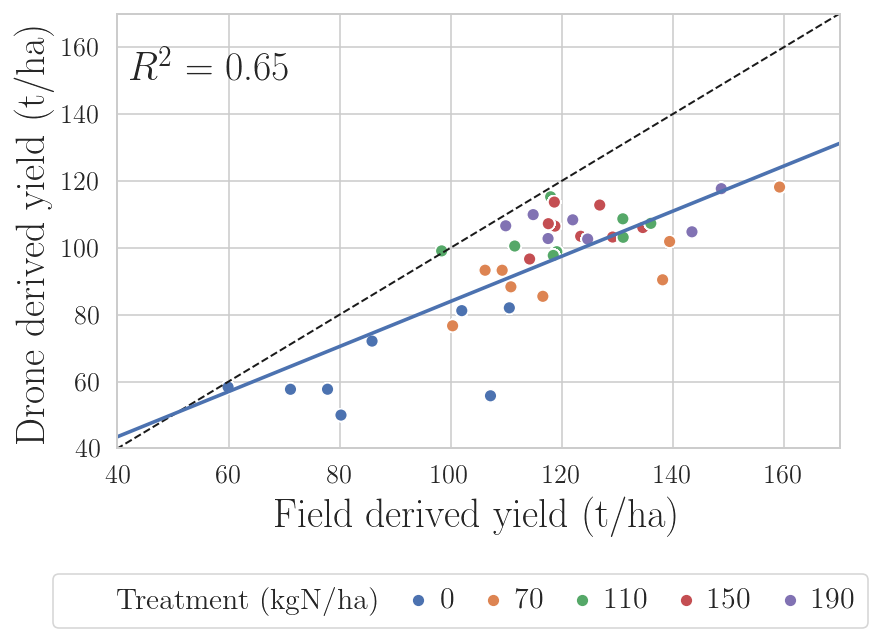

In [175]:
sns.set(context='paper',
        style='whitegrid',
        font='serif',
        font_scale=1.5, 
        rc={'text.usetex': True})
fsize=20

fig = plt.figure()
ax = plt.gca()

kwargs={'s':40}
sns.scatterplot(x="Total_Fresh_Biomass", y="Total_cell_biomass", hue="N_cat", data=merged_data, ax=ax, legend='full', **kwargs)


#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fancybox=True, fontsize=fsize).texts[0].set_text('Treatment\n (kgN/ha)')
plt.legend(loc='center', bbox_to_anchor=(0.475, -0.35), ncol=6,fontsize=15, handletextpad=-0.25, columnspacing=0.25).texts[0].set_text('Treatment (kgN/ha)')

plt.plot([30, 170], [30, 170], 'k--', linewidth=1)
sns.regplot(x='Total_Fresh_Biomass', y='Total_cell_biomass', data=merged_data, scatter=False, ci=None, ax=ax)
ax.set_xlabel('Field derived yield (t/ha)', fontsize=fsize)
ax.set_ylabel('Drone derived yield (t/ha)', fontsize=fsize)


plt.text(42, 150, "$R^2$ = " + str(round(r2_score_out, 2)), fontsize=fsize)
plt.xlim((40,170))
plt.ylim((40,170))
plt.savefig(img_path + 'Figure10b.pdf', bbox_inches='tight', dpi=600)

In [57]:
merged_data = gpd.GeoDataFrame(merged_data)

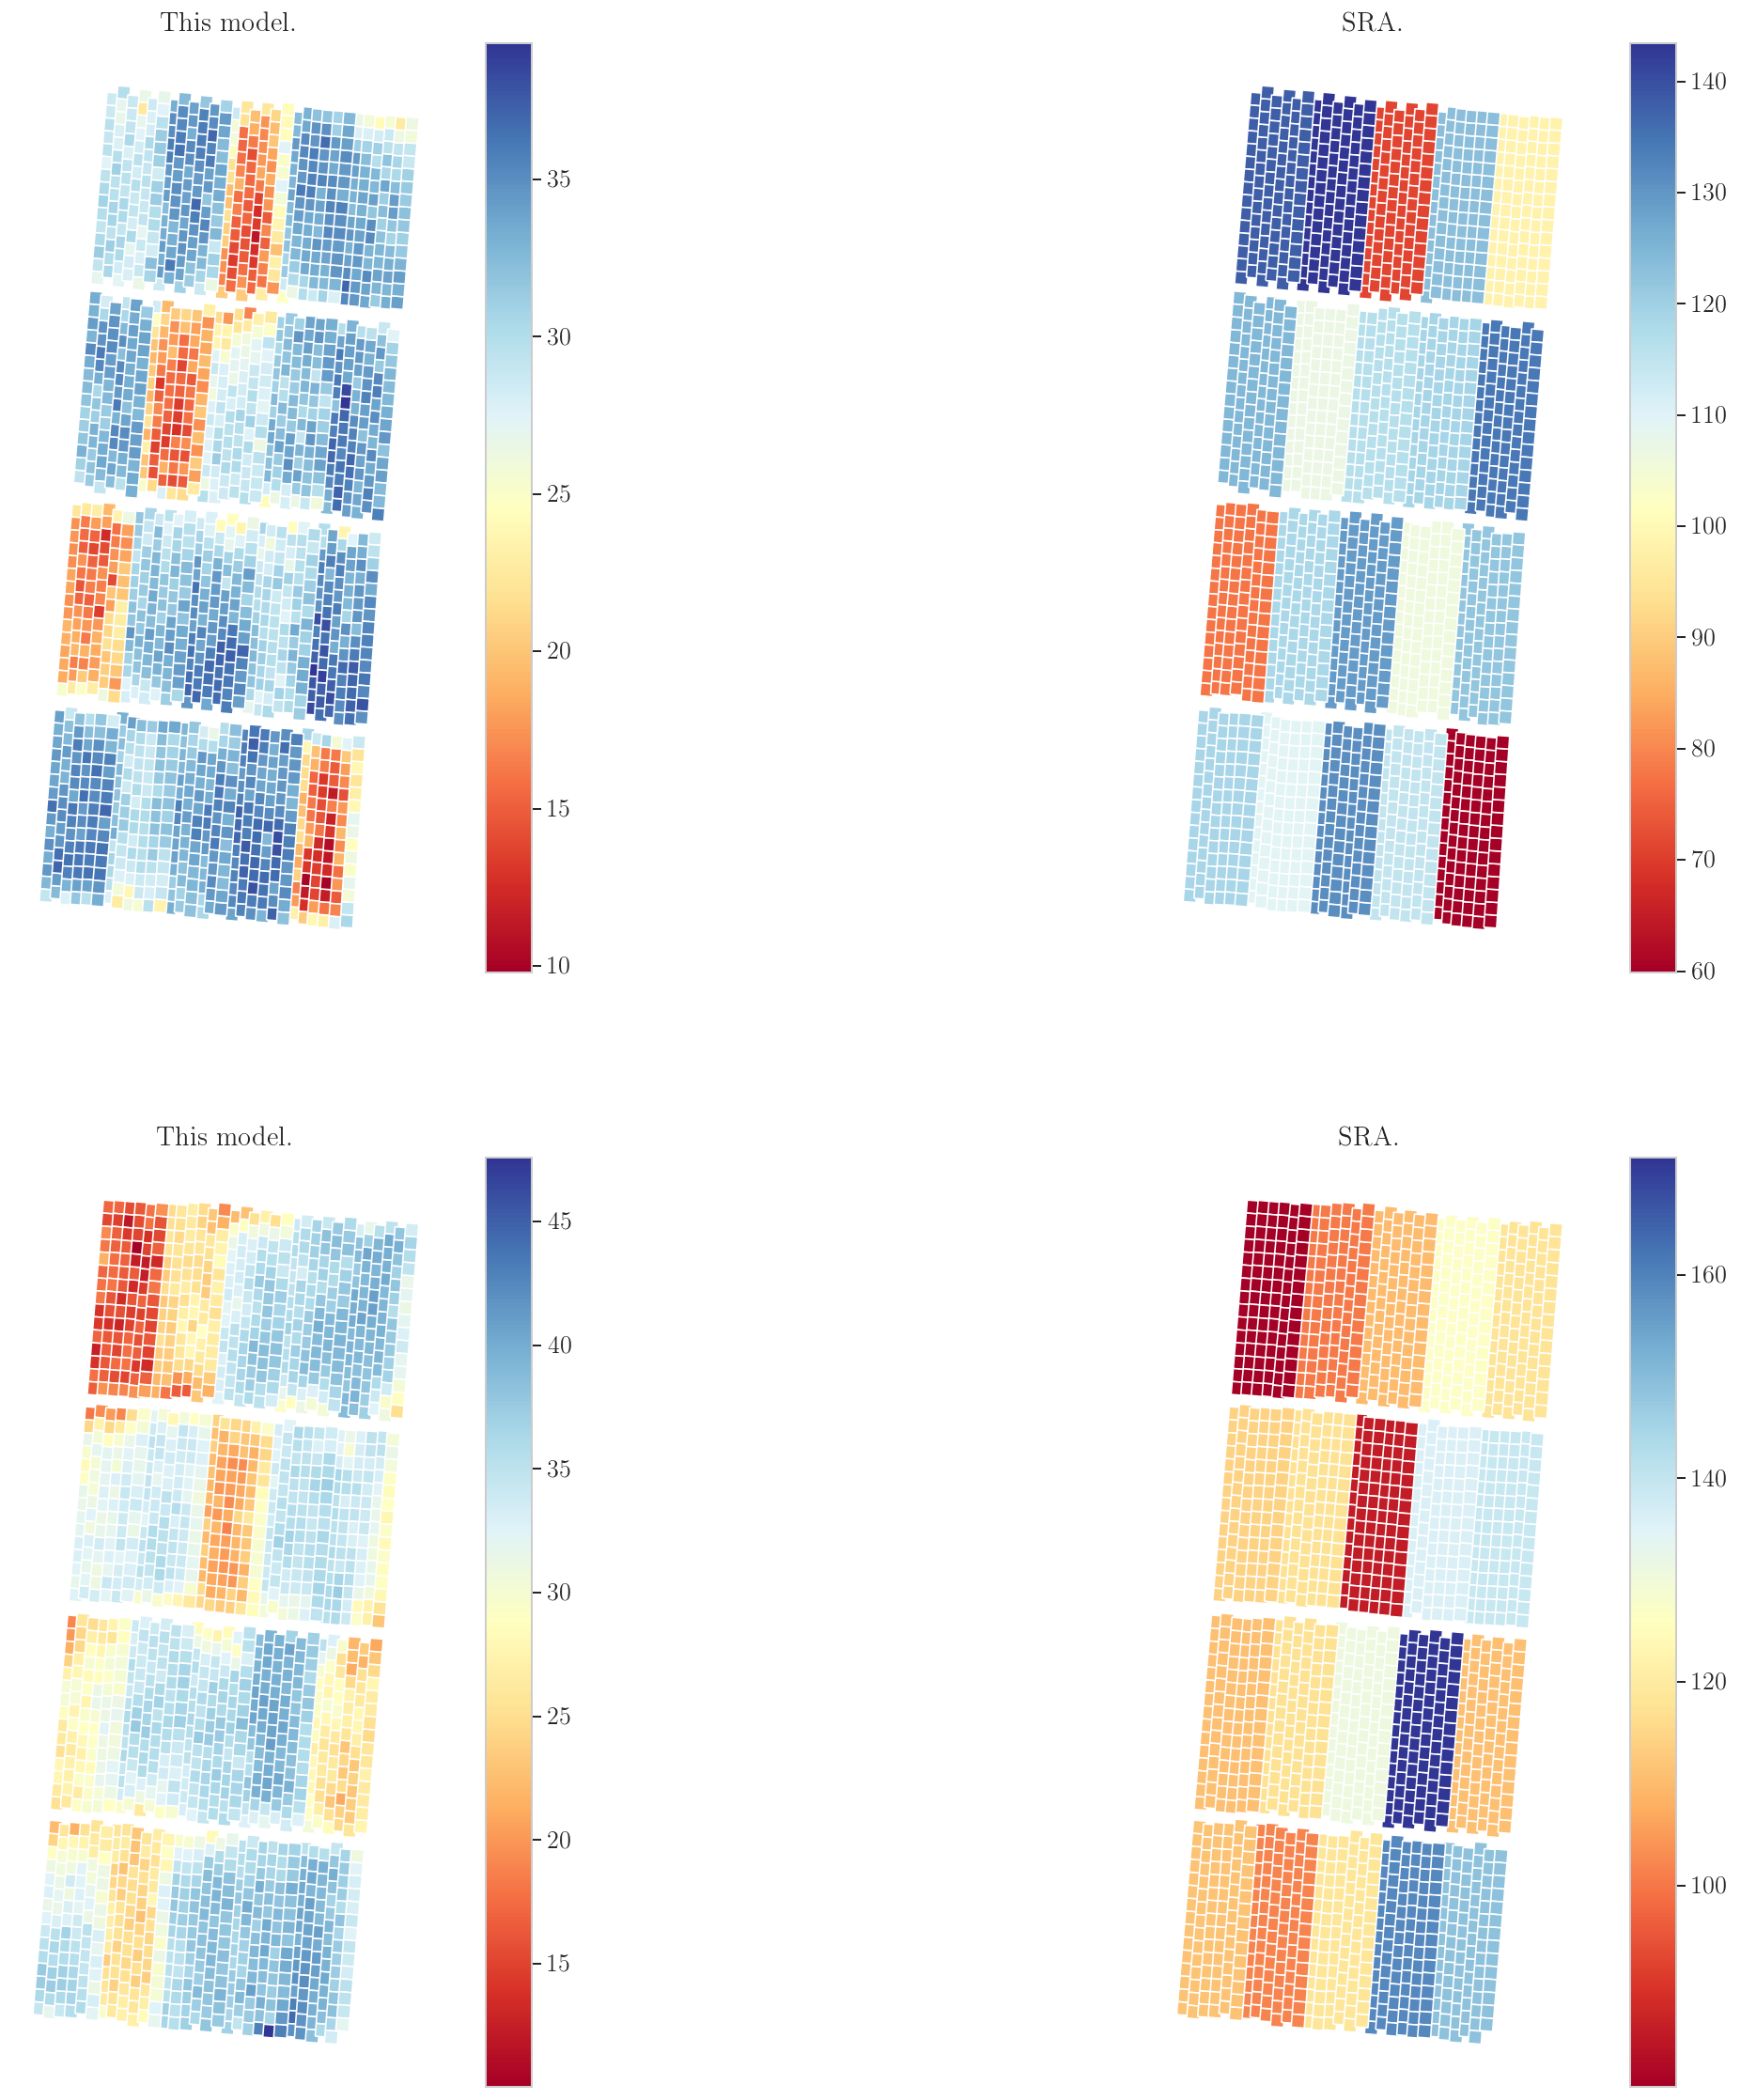

In [58]:
fig, ax = plt.subplots(2, 2, figsize=(20, 20))

# WT 1
A = (merged_data['FID'] == 'WT1')
B =  (merged_data['N_id'].astype(int) > 0)
ix = [a and b  for a,b in zip(A, B)]

merged_data.loc[ix].plot(column='Predicted Biomass', ax=ax[0,0], legend=True, cmap='RdYlBu')
merged_data.loc[ix].plot(column='Total_Fresh_Biomass', ax=ax[0,1], legend=True, cmap='RdYlBu')

ax[0,0].set_title('This model.')
ax[0,1].set_title('SRA.')
ax[1,0].set_title('This model.')
ax[1,1].set_title('SRA.')


# WT 2
A = (merged_data['FID'] == 'WT2')
B =  (merged_data['N_id'].astype(int) > 0)
ix = [a and b  for a,b in zip(A, B)]

merged_data.loc[ix].plot(column='Predicted Biomass', ax=ax[1,0], legend=True, cmap='RdYlBu')
merged_data.loc[ix].plot(column='Total_Fresh_Biomass', ax=ax[1,1], legend=True, cmap='RdYlBu')



for i in range(2):
    for j in range(2):
        ax[i,j].axis('off')


<a id="sec:leaf_nitrogen"></a>
# Leaf Nitrogen Prediction

In this section we now turn to predicting leaf nitrogen content. The data set used here is slightly different from the ones used above for biomass prediction. See section __ for a complete description.

The dependent variable to be predicted is now leaf nitrogen concentration (%). The predictors are 70 multispectral vegetation indices only; this time we do not have LiDAR observations.

We have $n = 160$ observations of the dependent variable: 40 observations in each of 4 time periods.

The strategy for this model is to pool all of the observations and include a quadratic time trend.

These data are stored in a spreadsheet (rather than shape file) and are located at `../Data/Leaf_N_Data/Leaf_Nitrogen.csv`.

<a id="sec:load_N_data"></a>
### Load and preprocess data

In [123]:
leafNpath = "./Data/Leaf_N_Data/Leaf_Nitrogen.csv"

leafNData = pd.read_csv(leafNpath, index_col='WT')
leafNData = leafNData.drop(columns=['Unnamed: 0'])

We're only interested in predicting total leaf nitrogen. Remove the extraneous variables.

Aso, drop any row with na (i.e., time periods where the dependent variable wasn't measured).

In [124]:
to_retain = [5, 6, 20] + list(range(22, 42)) + list(range(44, 104))
leafNData = leafNData.iloc[:, to_retain].dropna(axis=0)

Add a column for which survey the date corresponds to.

In [125]:
date_to_survey = {'20/12/2017': 'Survey \#2',
                  '31/01/2018': 'Survey \#3',
                  '15/03/2018': 'Survey \#4',
                  '26/04/2018': 'Survey \#5'}

# Function to map date to surevy number
def map_date_to_survey(date):
    return date_to_survey[date]
    
leafNData['Survey'] = leafNData['Date'].apply(map_date_to_survey)

In [126]:
print("Data shape:", leafNData.shape)
leafNData.head()

Data shape: (160, 84)


,Date,FIRST_N,Total_Nitr,avg_EVI,avg_GDVI,avg_GRVI,avg_NDRE,avg_NDVI,avg_SAVI,avg_SCCCI,...,std_GDVI,std_GRVI,std_NDRE,std_NDVI,std_SAVI,std_SCCCI,std_TCARI,std_TGI,std_VARI,Survey
WT,,,,,,,,,,,,,,,,,,,,,
WT1_1,20/12/2017,110,2.2,0.455192,0.670587,5.286308,0.448448,0.675800,0.551195,0.663381,...,0.060810,1.184842,0.074032,0.104472,0.081796,0.031147,3.263666,0.537575,0.015693,Survey \#2
WT1_10,20/12/2017,190,2.1,0.475883,0.688143,5.657835,0.476631,0.705230,0.574344,0.674742,...,0.060008,1.300060,0.075936,0.096176,0.081166,0.037384,2.903198,0.592005,0.014252,Survey \#2
WT1_11,20/12/2017,190,2.4,0.481287,0.687806,5.671763,0.477924,0.701750,0.574915,0.680619,...,0.062509,1.354964,0.078647,0.106226,0.083949,0.033744,3.507883,0.545341,0.015594,Survey \#2
WT1_12,20/12/2017,70,2.1,0.465787,0.675251,5.355899,0.455928,0.696101,0.564271,0.654960,...,0.058130,1.123955,0.068513,0.095784,0.080621,0.036669,3.436480,0.609781,0.014210,Survey \#2
WT1_13,20/12/2017,150,2.4,0.487199,0.686904,5.594220,0.474302,0.709735,0.581082,0.667798,...,0.056044,1.175735,0.071017,0.094947,0.080062,0.034269,3.244372,0.562890,0.013499,Survey \#2


From `avg_EVI` onwards are the multispectral predictors. `Total_Nitr` is the dependent variable to predict. `Date` and `FIRST_N` are the date and initial fertilizer application rate.

Note that there are 83 columns. 83 minus the 3 left-most variables (`Date`, `FIRST_N`, `Total_Nitr`) leaves 80 predictors, which is *not* equal to the 70 predictors we had in the multispectral model above. This data set contains some extra predictors (an extra statistic for each of the 7 vegetation indices) that we will need to remove in order to use the above PCA model.

160 observaions in each of 4 dates:

<a id="sec:leaf_N_over_time"></a>
## Leaf N over time

We mentioned above that our estimation strategy involves adding a quadratic time trend. Let's take a look at the distribution of leaf N concentration over time to see why.

In [127]:
index_list = leafNData.index.tolist()
WT1_ix = [i[0:3] == 'WT1' for i in index_list]
WT2_ix = [not(i) for i in WT1_ix]

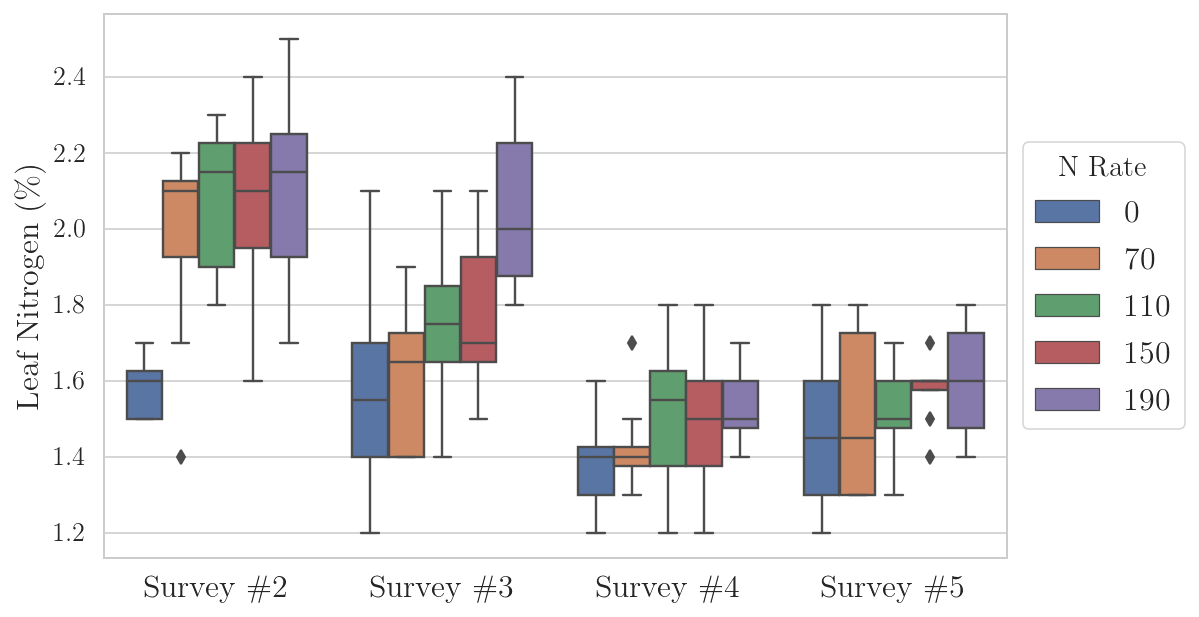

In [128]:
plt.figure(figsize=(1.618*5, 5))
fsize = 16

sns.boxplot(x='Survey', y='Total_Nitr', hue='FIRST_N', data=leafNData);
plt.ylabel('Leaf Nitrogen (\%)', fontsize=fsize);
plt.legend(title='N Rate', loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fsize)
plt.xlabel('')
plt.xticks(fontsize=fsize)

plt.savefig(img_path + 'Figure6.pdf',  bbox_inches='tight',dpi=600)


<a id="sec:PCA_projection"></a>
## PCA projection
In the next section we need to project the leaf N predictors through the PCA model estimated above. In order to do that we need to make sure that we have exactly the same set of predictors as before and that the predictors are in the same *order* as they were before.

First, construct two lists: the set of multispectral predictor variable names in the biomass prediction problem, and the same set of predictor names in this data set (recall we should have 10 extra). 

In [129]:
list1 = multispec_data.columns.tolist()
list2 = leafNData.columns.tolist()[3:]

print("Number of predictors for biomass: ", len(list1))
print("Number of predictors for leaf N: ", len(list2))

Number of predictors for biomass:  70
Number of predictors for leaf N:  81


Let's remove those additional 10 predictors.

In [130]:
to_drop = []

for i in list2:
    if not(i in list1):
        to_drop.append(i)
        
leafNData = leafNData.drop(columns=to_drop)

Now verify that we have the same set of predictors in the same order:

In [131]:
list2 = leafNData.columns.tolist()[3:]
print("Biomass \t Leaf N")
for i in range(len(list1)):
    print(f'{list1[i]} \t {list2[i]} \t {list1[i] == list2[i]}')

Biomass 	 Leaf N
avg_EVI 	 avg_EVI 	 True
avg_GDVI 	 avg_GDVI 	 True
avg_GRVI 	 avg_GRVI 	 True
avg_NDRE 	 avg_NDRE 	 True
avg_NDVI 	 avg_NDVI 	 True
avg_SAVI 	 avg_SAVI 	 True
avg_SCCCI 	 avg_SCCCI 	 True
avg_TCARI 	 avg_TCARI 	 True
avg_TGI 	 avg_TGI 	 True
avg_VARI 	 avg_VARI 	 True
max_EVI 	 max_EVI 	 True
max_GDVI 	 max_GDVI 	 True
max_GRVI 	 max_GRVI 	 True
max_NDRE 	 max_NDRE 	 True
max_NDVI 	 max_NDVI 	 True
max_SAVI 	 max_SAVI 	 True
max_SCCCI 	 max_SCCCI 	 True
max_TCARI 	 max_TCARI 	 True
max_TGI 	 max_TGI 	 True
max_VARI 	 max_VARI 	 True
min_EVI 	 min_EVI 	 True
min_GDVI 	 min_GDVI 	 True
min_GRVI 	 min_GRVI 	 True
min_NDRE 	 min_NDRE 	 True
min_NDVI 	 min_NDVI 	 True
min_SAVI 	 min_SAVI 	 True
min_SCCCI 	 min_SCCCI 	 True
min_TCARI 	 min_TCARI 	 True
min_TGI 	 min_TGI 	 True
min_VARI 	 min_VARI 	 True
p25_EVI 	 p25_EVI 	 True
p25_GDVI 	 p25_GDVI 	 True
p25_GRVI 	 p25_GRVI 	 True
p25_NDRE 	 p25_NDRE 	 True
p25_NDVI 	 p25_NDVI 	 True
p25_SAVI 	 p25_SAVI 	 True
p25_SCCCI 	 p

Great! We're ready to project these through our PCA model.

First we need to rescale the regressors according to the estimated variances from above,using `multispec_scale`. Then, project them through the PCA model using `multispec_pca.transform()`.

In [132]:
# Extract the predictors from the data frame.
leafN_predictors = leafNData.iloc[:, 3:]

# Divide through by the standard deviation estimated above
leafN_predictors = leafN_predictors / multispec_scale

# Project through PCA model
leafN_PCs = multispec_pca.transform(leafN_predictors)

Concatenate these principal components to the data.

In [133]:
# Put the PCs in a data frame and name the columns
leafN_PCs = pd.DataFrame(leafN_PCs, columns=['PC1', 'PC2', 'PC3', 'PC4'])
leafN_PCs = leafN_PCs.set_index(leafNData.index)

# Concat them to the main data set.
leafNData = pd.concat([leafNData, leafN_PCs], axis=1)
leafNData.head()

,Date,FIRST_N,Total_Nitr,avg_EVI,avg_GDVI,avg_GRVI,avg_NDRE,avg_NDVI,avg_SAVI,avg_SCCCI,...,std_NDVI,std_SAVI,std_SCCCI,std_TCARI,std_TGI,std_VARI,PC1,PC2,PC3,PC4
WT,,,,,,,,,,,,,,,,,,,,,
WT1_1,20/12/2017,110,2.2,0.455192,0.670587,5.286308,0.448448,0.675800,0.551195,0.663381,...,0.104472,0.081796,0.031147,3.263666,0.537575,0.015693,3.800380,-2.745856,6.209222,-1.776825
WT1_10,20/12/2017,190,2.1,0.475883,0.688143,5.657835,0.476631,0.705230,0.574344,0.674742,...,0.096176,0.081166,0.037384,2.903198,0.592005,0.014252,2.642675,-3.828417,7.955011,0.349320
WT1_11,20/12/2017,190,2.4,0.481287,0.687806,5.671763,0.477924,0.701750,0.574915,0.680619,...,0.106226,0.083949,0.033744,3.507883,0.545341,0.015594,2.604268,-3.839010,7.646059,-1.571389
WT1_12,20/12/2017,70,2.1,0.465787,0.675251,5.355899,0.455928,0.696101,0.564271,0.654960,...,0.095784,0.080621,0.036669,3.436480,0.609781,0.014210,3.621431,-2.829144,6.465419,0.008852
WT1_13,20/12/2017,150,2.4,0.487199,0.686904,5.594220,0.474302,0.709735,0.581082,0.667798,...,0.094947,0.080062,0.034269,3.244372,0.562890,0.013499,2.812982,-3.659226,6.389097,0.681294


<a id="subsec:time_trend"></a>
### Add time trend predictor
Data set is almost ready. Now we just need to add in terms for our time trend. 

We'll need time variable `T`, to use as a time trend. `T` will be the number of days until the final survey period, 2018-6-5. Note that the specific date for when $T=0$ is irrelevant, it's the number of days between observations that's important to capture, which is invariant to when the $T=0$ date is set to. 

In [134]:
final_survey = datetime.datetime(2018, 6, 5)

In [135]:
T = []
for date in leafNData['Date']:
    T.append((final_survey - datetime.datetime.strptime(date, '%d/%m/%Y')).days)
T = np.array(T)

In [136]:
leafNData['T'] = T
leafNData['T2'] = T**2

In [137]:
leafNData.head(1)

,Date,FIRST_N,Total_Nitr,avg_EVI,avg_GDVI,avg_GRVI,avg_NDRE,avg_NDVI,avg_SAVI,avg_SCCCI,...,std_SCCCI,std_TCARI,std_TGI,std_VARI,PC1,PC2,PC3,PC4,T,T2
WT,,,,,,,,,,,,,,,,,,,,,
WT1_1,20/12/2017,110,2.2,0.455192,0.670587,5.286308,0.448448,0.6758,0.551195,0.663381,...,0.031147,3.263666,0.537575,0.015693,3.80038,-2.745856,6.209222,-1.776825,167,27889


Great! Data set is ready to go. Let's run our regression.

<a id="sec:leaf_N_model"></a>
## Regression model

We want to regress `Total_Nitr` against a constant, `T`, `T2`, and `PC1` through `PC4`.

In [138]:
regressors = ['T', 'T2', 'PC1', 'PC2', 'PC3', 'PC4']

y = leafNData['Total_Nitr']
X = leafNData[regressors]
X['const'] = 1

/home/gar303/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [139]:
model = sm.OLS(y, X).fit(cov_type='HC0')
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Total_Nitr   R-squared:                       0.586
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     48.12
Date:                Wed, 06 Nov 2019   Prob (F-statistic):           7.86e-33
Time:                        09:56:47   Log-Likelihood:                 35.427
No. Observations:                 160   AIC:                            -56.85
Df Residuals:                     153   BIC:                            -35.33
Df Model:                           6                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -0.0043      0.002     -2.270      0.023      -0.008      -0.001
T2          2.169e-05   1.01e-05      2.145      0.032    1.87e-06    4.15e-05
PC1            0.0158      0.007      2.346      0.019       0.003       0.029
PC2           -0.0372      0.008     -4.740      0.000      -0.053      -0.022
PC3            0.0422      0.009      4.559      0.000       0.024       0.060
PC4           -0.0511      0.009     -5.470      0.000      -0.069      -0.033
const          1.7750      0.079     22.592      0.000       1.621       1.929
==============================================================================
Omnibus:                        3.245   Durbin-Watson:                   2.155
Prob(Omnibus):                  0.197   Jarque-Bera (JB):                3.345
Skew:                           0.121   Prob(JB):                        0.188
Kurtosis:                       3.666   Cond. No.                     1.00e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large,  1e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [140]:
# Generate a data frame containing predicted leaf N and observed leaf N.
y_hat = model.predict(X)
df = pd.DataFrame({'Observed': y, 'Predicted': y_hat, 'N': leafNData['FIRST_N']})

temp = df['N'].tolist()
temp = pd.Categorical(["$" + str(i) + "$" for i in temp])
temp.categories
new_order = ['$0$', '$70$', '$110$', '$150$', '$190$'] 
temp = temp.reorder_categories(new_order)
temp.categories
df['Ncat'] = temp


Actual/Predicted plot:

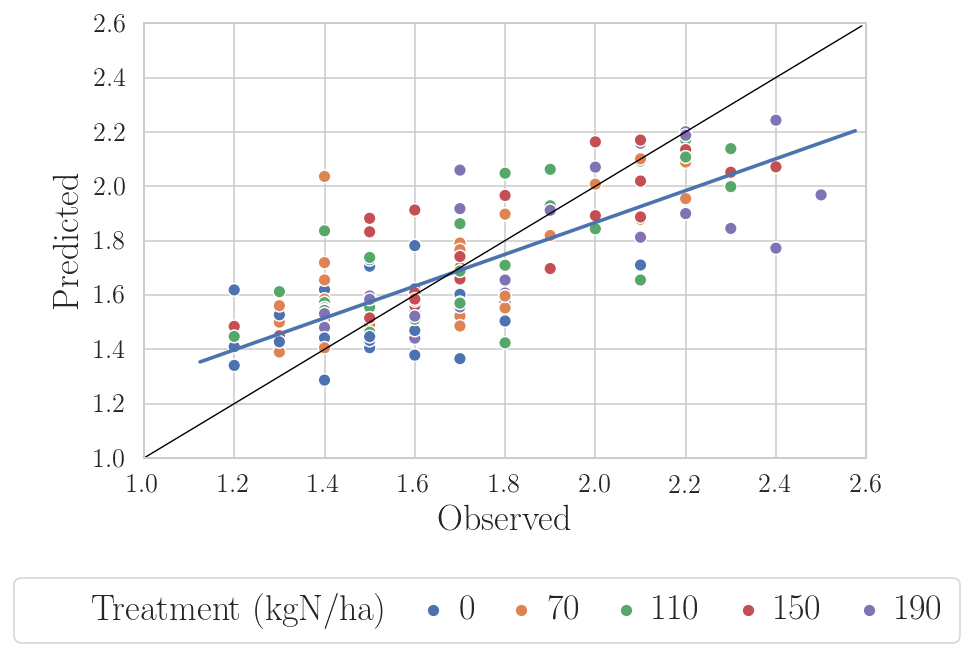

In [171]:
# Scatter these and add a 45 degree line corresponding to perfect predictions.
fsize = 18
kwargs={'s':40}


sns.scatterplot(x='Observed', y='Predicted', hue='Ncat', data=df, **kwargs)
sns.regplot(x='Observed', y='Predicted', data=df, ci=None, scatter=False)

plt.xlim(1, 2.6)
plt.ylim(1, 2.6)
x = np.arange(1, 2.6, 0.01)
y = x
plt.plot(x, y, color='black', linewidth=0.7)
plt.legend(loc='center', bbox_to_anchor=(0.475, -0.35), ncol=6,fontsize=fsize, handletextpad=-0.25, columnspacing=0.25).texts[0].set_text('Treatment (kgN/ha)')
plt.xlabel('Observed', fontsize=fsize)
plt.ylabel('Predicted', fontsize=fsize)
plt.savefig(img_path + 'Figure9.pdf', bbox_inches='tight', dpi=600)

<a id="sec:Benchmark_avgNDVI"></a>
### Benchmark - Avg NDVI

Just have X be a constant and avgNDVI

In [78]:
regressors = ['T', 'T2', 'avg_NDVI']

y = leafNData['Total_Nitr']
X = leafNData[regressors]
X['const'] = 1

benchmark_model = sm.OLS(y, X).fit(cov_type='HC0')
benchmark_model.summary()

/home/gar303/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Total_Nitr   R-squared:                       0.397
Model:                            OLS   Adj. R-squared:                  0.385
Method:                 Least Squares   F-statistic:                     29.78
Date:                Wed, 06 Nov 2019   Prob (F-statistic):           2.80e-15
Time:                        09:38:26   Log-Likelihood:                 5.3253
No. Observations:                 160   AIC:                            -2.651
Df Residuals:                     156   BIC:                             9.650
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -0.0044      0.002     -2.106      0.035      -0.008      -0.000
T2          4.009e-05   1.05e-05      3.818      0.000    1.95e-05    6.07e-05
avg_NDVI       0.3298      0.427      0.772      0.440      -0.507       1.167
const          1.3553      0.358      3.791      0.000       0.655       2.056
==============================================================================
Omnibus:                        0.540   Durbin-Watson:                   1.892
Prob(Omnibus):                  0.764   Jarque-Bera (JB):                0.537
Skew:                           0.137   Prob(JB):                        0.764
Kurtosis:                       2.924   Cond. No.                     4.38e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 4.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<a id="sec:Benchmark_maxNDVI"></a>
### Benchmark - Max NDVI

In [79]:
regressors = ['T', 'T2', 'max_NDVI']

y = leafNData['Total_Nitr']
X = leafNData[regressors]
X['const'] = 1

benchmark_model = sm.OLS(y, X).fit(cov_type='HC0')
benchmark_model.summary()

/home/gar303/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Total_Nitr   R-squared:                       0.400
Model:                            OLS   Adj. R-squared:                  0.388
Method:                 Least Squares   F-statistic:                     30.38
Date:                Wed, 06 Nov 2019   Prob (F-statistic):           1.60e-15
Time:                        09:38:26   Log-Likelihood:                 5.7161
No. Observations:                 160   AIC:                            -3.432
Df Residuals:                     156   BIC:                             8.869
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -0.0041      0.002     -1.981      0.048      -0.008   -4.29e-05
T2          3.872e-05   1.03e-05      3.747      0.000    1.85e-05     5.9e-05
max_NDVI       0.7293      0.601      1.213      0.225      -0.449       1.908
const          0.9430      0.563      1.675      0.094      -0.161       2.046
==============================================================================
Omnibus:                        0.628   Durbin-Watson:                   1.884
Prob(Omnibus):                  0.731   Jarque-Bera (JB):                0.553
Skew:                           0.143   Prob(JB):                        0.758
Kurtosis:                       2.974   Cond. No.                     7.16e+05
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 7.16e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<a id="sec:Benchmark_N"></a>
### Benchmark 3 - N rate

In [80]:
regressors = ['T', 'T2', 'FIRST_N']

y = leafNData['Total_Nitr']
X = leafNData[regressors]
X['const'] = 1

benchmark_model = sm.OLS(y, X).fit(cov_type='HC0')
benchmark_model.summary()

/home/gar303/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Total_Nitr   R-squared:                       0.513
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     48.05
Date:                Wed, 06 Nov 2019   Prob (F-statistic):           4.73e-22
Time:                        09:38:26   Log-Likelihood:                 22.470
No. Observations:                 160   AIC:                            -36.94
Df Residuals:                     156   BIC:                            -24.64
Df Model:                           3                                         
Covariance Type:                  HC0                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -0.0043      0.002     -2.284      0.022      -0.008      -0.001
T2          3.887e-05   9.31e-06      4.173      0.000    2.06e-05    5.71e-05
FIRST_N        0.0016      0.000      5.919      0.000       0.001       0.002
const          1.4579      0.090     16.288      0.000       1.282       1.633
==============================================================================
Omnibus:                        1.224   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.542   Jarque-Bera (JB):                1.284
Skew:                           0.203   Prob(JB):                        0.526
Kurtosis:                       2.833   Cond. No.                     9.07e+04
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
[2] The condition number is large, 9.07e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<a id="sec:ftests_leaf_N"></a>
## F-tests for leaf N

Compare Multispectral model with N and without N.

In [81]:
regressors = ['T', 'T2', 'PC1', 'PC2', 'PC3', 'PC4', 'FIRST_N']

y = leafNData['Total_Nitr']
X = leafNData[regressors]
X['const'] = 1

N_model = sm.OLS(y, X).fit(cov_type='HC0')
print(N_model.summary())

regressors = ['T', 'T2', 'PC1', 'PC2', 'PC3', 'PC4']
y = leafNData['Total_Nitr']
X = leafNData[regressors]
X['const'] = 1

No_N_model = sm.OLS(y, X).fit(cov_type='HC0')
print(No_N_model.summary())

N_model.compare_f_test(No_N_model)

                            OLS Regression Results                            
Dep. Variable:             Total_Nitr   R-squared:                       0.600
Model:                            OLS   Adj. R-squared:                  0.582
Method:                 Least Squares   F-statistic:                     44.47
Date:                Wed, 06 Nov 2019   Prob (F-statistic):           9.94e-34
Time:                        09:38:26   Log-Likelihood:                 38.265
No. Observations:                 160   AIC:                            -60.53
Df Residuals:                     152   BIC:                            -35.93
Df Model:                           7                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
T             -0.0041      0.002     -2.116      0.0

/home/gar303/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/gar303/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/gar303/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:2018: InvalidTestWarning: F test for comparison is likely invalid with robust covariance, proceeding anyway
  InvalidTestWarning)


(5.4904041668137005, 0.02041669722625054, 1.0)

Roughly a 0.015 increase in $R^{2}$. This is statistically significant ($p = 0.02$), but not a substantial increase.

Done!